# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model


#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual.reshape(1,self.imsize)-self.img.reshape(1,self.imsize))/self.imsize

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(self.imsize)-self.img.reshape(self.imsize))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])
model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [6]:
model.load_weights('CNN_MNIST.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

# Prepare Data

In [0]:
import pickle
file_ = open('subset', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((784,1)),
    "input_size" : 28*28,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 100, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  -1.6005099187180387 25
50  :  -1.2400235387096101 25
75  :  -1.3436853148371226 25
100  :  -1.0361475049194016 25
125  :  -1.011453312348822 25
150  :  -0.9711838564955046 25
175  :  -0.9281899047062052 25
200  :  -0.9575922273802338 25
225  :  -0.9575922273802338 25
250  :  -0.9575922273802338 25
275  :  -0.920241462213613 25
300  :  -0.9273155219922815 25
325  :  -0.9140078547512418 25
350  :  -0.8915207061113044 25
375  :  -0.8830400891356542 25
400  :  -0.8385802065595795 25
425  :  -0.815552496044083 25
450  :  -0.8151506029024607 25
475  :  -0.7946293313762218 25
500  :  -0.7702130181112059 25
525  :  -0.7707071864609123 25
550  :  -0.7703332723075971 25
575  :  -0.7696767420276962 25
600  :  -0.7477228477261517 25
625  :  -0.7477228477261517 25
650  :  -0.7383311367863845 25
675  :  -0.7219879469658335 25
700  :  -0.7219879469658335 25
725  :  -0.7190280268030416 25
750  :  -0.7190280268030416 25
775  :  -0.718563700008821 25
800  :  -0.7156974506521387 25
825  :  -0.7092

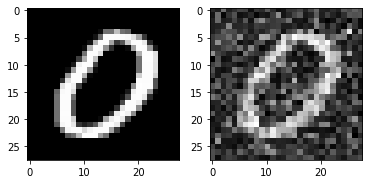

25  :  -1.553417676053468 25
50  :  -1.553417676053468 25
75  :  -1.378809991276332 25
100  :  -1.0218994613827503 25
125  :  -0.9171860152546578 25
150  :  -0.9171860152546578 25
175  :  -0.9171860152546578 25
200  :  -0.9171860152546578 25
225  :  -0.9171860152546578 25
250  :  -0.9121290512041145 25
275  :  -0.8779064755473249 25
300  :  -0.8779064755473249 25
325  :  -0.8779064755473249 25
350  :  -0.8779064755473249 25
375  :  -0.8779064755473249 25
400  :  -0.8724079761200771 25
425  :  -0.8147280128733723 25
450  :  -0.8147280128733723 25
475  :  -0.8147280128733723 25
500  :  -0.7890100656117158 25
525  :  -0.7663948608470108 25
550  :  -0.7613514485925257 25
575  :  -0.7295102620968215 25
600  :  -0.7287047549252934 25
625  :  -0.7249323820395992 25
650  :  -0.7011508897095313 25
675  :  -0.6997745995573683 25
700  :  -0.6940837930660946 25
725  :  -0.6940837930660946 25
750  :  -0.6940837930660946 25
775  :  -0.6838353897313478 25
800  :  -0.6838353897313478 25
825  :  -0.681

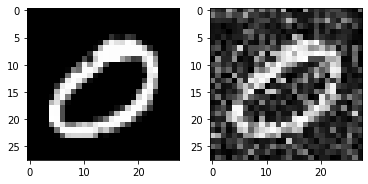

25  :  -1.5348737504155654 25
50  :  -1.5348737504155654 25
75  :  -1.5221616353753231 25
100  :  -1.4745873416734352 25
125  :  -1.3573475609085266 25
150  :  -1.4736124806849296 25
175  :  -1.4736124806849296 25
200  :  -1.4596755115302242 25
225  :  -1.444187851453926 25
250  :  -1.403263037327379 25
275  :  -1.3947619160509452 25
300  :  -1.3935882379399707 25
325  :  -1.3935882379399707 25
350  :  -1.3863683200901815 25
375  :  -1.3647128990546886 25
400  :  -1.3647128990546886 25
425  :  -1.362820695630974 25
450  :  -1.3510857352711367 25
475  :  -1.3510850352144868 25
500  :  -1.3457858795085444 25
525  :  -1.3457845512350257 25
550  :  -1.3451671001118002 25
575  :  -1.3406182546726237 25
600  :  -1.3379286816057365 25
625  :  -1.3379286816057365 25
650  :  -1.3358102437175836 25
675  :  -1.332355236180652 25
700  :  -1.332355236180652 25
725  :  -1.3312817003238098 25
750  :  -1.3312817003238098 25
775  :  -1.330262241703387 25
800  :  -1.326558924422659 25
825  :  -1.3203034

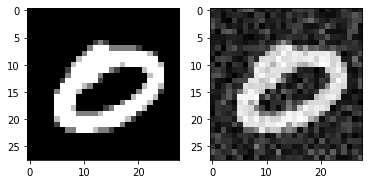

25  :  -0.9303377732454736 25
50  :  -0.9303377732454736 25
75  :  -0.9303377732454736 25
100  :  -0.8796638676252142 25
125  :  -0.8796638676252142 25
150  :  -0.8796638676252142 25
175  :  -0.8796638676252142 25
200  :  -0.8784718385831392 25
225  :  -0.8256850303062586 25
250  :  -0.8256850303062586 25
275  :  -0.8256850303062586 25
300  :  -0.7975396629581353 25
325  :  -0.7924018507583586 25
350  :  -0.754956126585117 25
375  :  -0.7519296789841525 25
400  :  -0.747379547747306 25
425  :  -0.7459416373247951 25
450  :  -0.7295026418504846 25
475  :  -0.6995386258904828 25
500  :  -0.6995386258904828 25
525  :  -0.6976589601198653 25
550  :  -0.6976589601198653 25
575  :  -0.6976589601198653 25
600  :  -0.6976589601198653 25
625  :  -0.6976589601198653 25
650  :  -0.6790923990912663 25
675  :  -0.6790923990912663 25
700  :  -0.6780902797953836 25
725  :  -0.6780902797953836 25
750  :  -0.6736605536932663 25
775  :  -0.667189232360883 25
800  :  -0.6670995090015779 25
825  :  -0.664

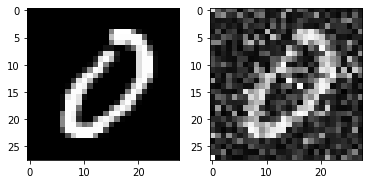

25  :  -0.7758689723622938 25
50  :  -0.7758689723622938 25
75  :  -0.8027700578270949 25
100  :  -0.7659795937848399 25
125  :  -0.7688011726464179 25
150  :  -0.7688011726464179 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


175  :  -0.7688011726464179 25
200  :  -0.7688011726464179 25
225  :  -0.7688011726464179 25
250  :  -0.7688011726464179 25
275  :  -0.7688011726464179 25
300  :  -0.7688011726464179 25
325  :  -0.7688011726464179 25
350  :  -0.7688011726464179 25
375  :  -0.7688011726464179 25
400  :  -0.7688011726464179 25
425  :  -0.7688011726464179 25
450  :  -0.7688011726464179 25
475  :  -0.7688011726464179 25
500  :  -0.7688011726464179 25
525  :  -0.7688011726464179 25
550  :  -0.7688011726464179 25
575  :  -0.7688011726464179 25
600  :  -0.7688011726464179 25
625  :  -0.7688011726464179 25
650  :  -0.7688011726464179 25
675  :  -0.7688011726464179 25
700  :  -0.7688011726464179 25
725  :  -0.7688011726464179 25
750  :  -0.7688011726464179 25
775  :  -0.7688011726464179 25
800  :  -0.7688011726464179 25
825  :  -0.7688011726464179 25
850  :  -0.7688011726464179 25
875  :  -0.7688011726464179 25
Time:  45.49690914154053  seconds
Predicted class:  [8]


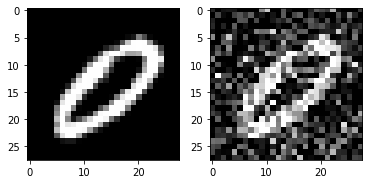

25  :  -1.082400823613254 25
50  :  -0.9124517943685095 25
75  :  -0.8799728939560245 25
100  :  -0.8575628495427847 25
125  :  -0.8359673968666586 25
150  :  -0.8359673968666586 25
175  :  -0.8331055839579153 25
200  :  -0.8062209825880557 25
225  :  -0.8021483435505277 25
250  :  -0.8021483435505277 25
275  :  -0.8021483435505277 25
300  :  -0.8021483435505277 25
325  :  -0.771991515167219 25
350  :  -0.771991515167219 25
375  :  -0.771991515167219 25
400  :  -0.7700053060007905 25
425  :  -0.7698514093734612 25
450  :  -0.7698514093734612 25
475  :  -0.7288348879800299 25
500  :  -0.7295818773836749 25
525  :  -0.7168232866041613 25
550  :  -0.715805524723391 25
575  :  -0.6705496838333329 25
600  :  -0.6705496838333329 25
625  :  -0.6705496838333329 25
650  :  -0.6705496838333329 25
675  :  -0.6705496838333329 25
700  :  -0.6705496838333329 25
725  :  -0.6660925022825384 25
750  :  -0.6635978764221169 25
775  :  -0.6435327895973726 25
800  :  -0.6310552029068552 25
825  :  -0.62385

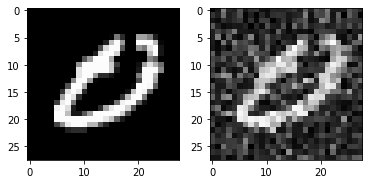

25  :  -1.6180494050856062 25
50  :  -1.5143190698180042 25
75  :  -1.5143190698180042 25
100  :  -1.505592835510081 25
125  :  -1.5000469314598228 25
150  :  -1.4842423835149918 25
175  :  -1.4234096704323167 25
200  :  -1.4234096704323167 25
225  :  -1.3957650422776808 25
250  :  -1.3957650422776808 25
275  :  -1.3953908569510656 25
300  :  -1.3890211721072907 25
325  :  -1.3745831496584018 25
350  :  -1.3745831496584018 25
375  :  -1.349789820930312 25
400  :  -1.343228293631985 25
425  :  -1.3385447887212365 25
450  :  -1.3377535802083809 25
475  :  -1.3218868135502717 25
500  :  -1.3218868135502717 25
525  :  -1.3183882781335217 25
550  :  -1.311650053327447 25
575  :  -1.311650053327447 25
600  :  -1.3060745032680643 25
625  :  -1.3031419422792139 25
650  :  -1.298315663817676 25
675  :  -1.2978700546466184 25
700  :  -1.2978700546466184 25
725  :  -1.2953495761073082 25
750  :  -1.2943157329573738 25
775  :  -1.2899219978835026 25
800  :  -1.2899219978835026 25
825  :  -1.288183

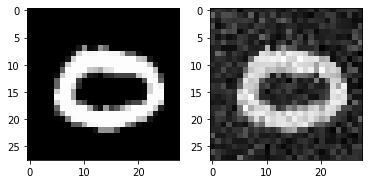

25  :  -1.0978379124909863 25
50  :  -0.9833372741722037 25
75  :  -0.9766376977408469 25
100  :  -0.9766376977408469 25
125  :  -0.9766376977408469 25
150  :  -0.9766376977408469 25
175  :  -0.9766376977408469 25
200  :  -0.9323483185994368 25
225  :  -0.9348028011909384 25
250  :  -0.8828905912670022 25
275  :  -0.8384154862772242 25
300  :  -0.833885569331339 25
325  :  -0.833885569331339 25
350  :  -0.8084671637055463 25
375  :  -0.8117403826480045 25
400  :  -0.8117403826480045 25
425  :  -0.7896816831769093 25
450  :  -0.7716259210113943 25
475  :  -0.7744934337215306 25
500  :  -0.7744934337215306 25
525  :  -0.7744934337215306 25
550  :  -0.7616737222889702 25
575  :  -0.7584853023398814 25
600  :  -0.7394999470073123 25
625  :  -0.7227807192940947 25
650  :  -0.7123824833433974 25
675  :  -0.7123824833433974 25
700  :  -0.7113344905168091 25
725  :  -0.7051801754878129 25
750  :  -0.7015156753299108 25
775  :  -0.6921949658667674 25
800  :  -0.6771984845223482 25
825  :  -0.67

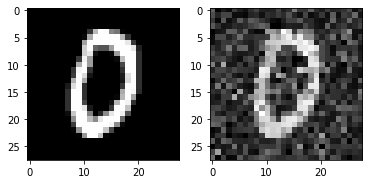

25  :  -0.7976968268756446 25
50  :  -0.7976968268756446 25
75  :  -0.7976968268756446 25
100  :  -0.74284648242542 25
125  :  -0.7573431807973572 25
150  :  -0.7573431807973572 25
175  :  -0.7204207602031212 25
200  :  -0.6997207691330993 25
225  :  -0.7014735632090348 25
250  :  -0.6816000808415492 25
275  :  -0.6816000808415492 25
300  :  -0.6299887860682785 25
325  :  -0.6293110581116361 25
350  :  -0.6293110581116361 25
375  :  -0.6293110581116361 25
400  :  -0.5841008396057741 25
425  :  -0.5853006345771219 25
450  :  -0.5654482293815057 25
475  :  -0.5653087498147165 25
500  :  -0.5653087498147165 25
525  :  -0.5653087498147165 25
550  :  -0.5653087498147165 25
575  :  -0.5653087498147165 25
600  :  -0.5653087498147165 25
625  :  -0.5651864371924185 25
650  :  -0.5615207599494485 25
675  :  -0.5545449841125025 25
700  :  -0.5489899287385993 25
725  :  -0.5489899287385993 25
750  :  -0.519591006045834 25
775  :  -0.519591006045834 25
800  :  -0.5118689945658361 25
825  :  -0.5075

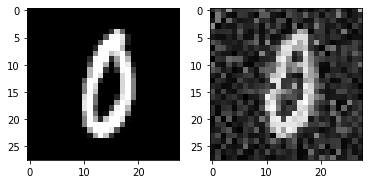

25  :  -0.9673012913855008 25
50  :  -0.9673012913855008 25
75  :  -0.9595589188189177 25
100  :  -0.8400400453029542 25
125  :  -0.8413349055161436 25
150  :  -0.8413349055161436 25
175  :  -0.8413349055161436 25
200  :  -0.8413349055161436 25
225  :  -0.8413349055161436 25
250  :  -0.8413349055161436 25
275  :  -0.8413349055161436 25
300  :  -0.8144166116474674 25
325  :  -0.8108637244402148 25
350  :  -0.8108637244402148 25
375  :  -0.8108637244402148 25
400  :  -0.8045148204812396 25
425  :  -0.8036582000132453 25
450  :  -0.7783659269033731 25
475  :  -0.7618080518778436 25
500  :  -0.7618818552047184 25
525  :  -0.7224056144641609 25
550  :  -0.7218208982387644 25
575  :  -0.7218208982387644 25
600  :  -0.7218208982387644 25
625  :  -0.7218208982387644 25
650  :  -0.7188317628141692 25
675  :  -0.6988642171516037 25
700  :  -0.6988725842008143 25
725  :  -0.6842355915063238 25
750  :  -0.6845009924380259 25
775  :  -0.6838697356007186 25
800  :  -0.6808976123142063 25
825  :  -0.

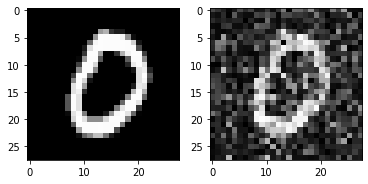

25  :  -0.8442172870850457 25
50  :  -0.8442172870850457 25
75  :  -0.8571907774336913 25
100  :  -0.8145033625202092 25
125  :  -0.8145033625202092 25
150  :  -0.8145033625202092 25
175  :  -0.7167037805978427 25
200  :  -0.7167037805978427 25
225  :  -0.7167037805978427 25
250  :  -0.7167037805978427 25
275  :  -0.7167037805978427 25
300  :  -0.7167037805978427 25
325  :  -0.7167037805978427 25
350  :  -0.6997660980742364 25
375  :  -0.7042262599159315 25
400  :  -0.7042262599159315 25
425  :  -0.7042262599159315 25
450  :  -0.6959105820193854 25
475  :  -0.6959105820193854 25
500  :  -0.6746445352781334 25
525  :  -0.674637664201085 25
550  :  -0.667482027148526 25
575  :  -0.667482027148526 25
600  :  -0.6565558349339633 25
625  :  -0.6565558349339633 25
650  :  -0.6428907655430418 25
675  :  -0.6405051225158258 25
700  :  -0.6220513267655992 25
725  :  -0.6094266804625375 25
750  :  -0.6094266804625375 25
775  :  -0.5938859537078407 25
800  :  -0.5933643696999489 25
825  :  -0.589

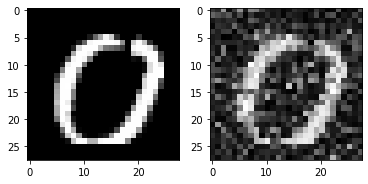

25  :  -1.516080724598265 25
50  :  -1.516080724598265 25
75  :  -1.2339210136982026 25
100  :  -1.0850806052996065 25
125  :  -1.0850806052996065 25
150  :  -1.0821351617591874 25
175  :  -0.9927886964137564 25
200  :  -0.9520150084272834 25
225  :  -0.9540392933232151 25
250  :  -0.8759389484431532 25
275  :  -0.8657847362534343 25
300  :  -0.8657847362534343 25
325  :  -0.8578072973224959 25
350  :  -0.8237115762192302 25
375  :  -0.8237115762192302 25
400  :  -0.811966591199994 25
425  :  -0.8115371033344498 25
450  :  -0.8115371033344498 25
475  :  -0.8081241554707852 25
500  :  -0.7855454590945481 25
525  :  -0.7855454590945481 25
550  :  -0.7855454590945481 25
575  :  -0.778425819461491 25
600  :  -0.777776632756084 25
625  :  -0.7731715539860449 25
650  :  -0.7733109602738382 25
675  :  -0.7718439238480406 25
700  :  -0.7674158900783183 25
725  :  -0.762338043614714 25
750  :  -0.7622920430088247 25
775  :  -0.7608793209492903 25
800  :  -0.7609201285699783 25
825  :  -0.758490

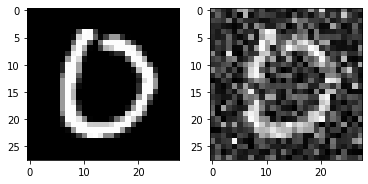

25  :  -0.6661286186400643 25
50  :  -0.6191841715426778 25
75  :  -0.5535706622341847 25
100  :  -0.5535706622341847 25
125  :  -0.5465479010610028 25
150  :  -0.5287865978640482 25
175  :  -0.5182599174971474 25
200  :  -0.4668906656498303 25
225  :  -0.4668906656498303 25
250  :  -0.4327618349026282 25
275  :  -0.42217960801541077 25
300  :  -0.4052349839718328 25
325  :  -0.4052349839718328 25
350  :  -0.40041287844438256 25
375  :  -0.39095206243344294 25
400  :  -0.36368788180087874 25
425  :  -0.36368788180087874 25
450  :  -0.36368788180087874 25
475  :  -0.36368788180087874 25
500  :  -0.36368788180087874 25
525  :  -0.33467457169448134 25
550  :  -0.33467457169448134 25
575  :  -0.33467457169448134 25
600  :  -0.33467457169448134 25
625  :  -0.33467457169448134 25
650  :  -0.33467457169448134 25
675  :  -0.33467457169448134 25
700  :  -0.33467457169448134 25
725  :  -0.331510124516482 25
750  :  -0.331510124516482 25
775  :  -0.3296970227735503 25
800  :  -0.3296970227735503 

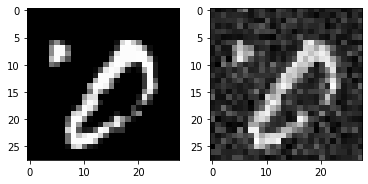

25  :  -0.6907868874630381 25
50  :  -0.6681132718855014 25
75  :  -0.603776750975388 25
100  :  -0.5214854949009204 25
125  :  -0.5209365157666415 25
150  :  -0.519182004542668 25
175  :  -0.5079138407232199 25
200  :  -0.5079138407232199 25
225  :  -0.49515774671583435 25
250  :  -0.4997390458319283 25
275  :  -0.4878322742538229 25
300  :  -0.4415292517854036 25
325  :  -0.44224284813994774 25
350  :  -0.44224284813994774 25
375  :  -0.44224284813994774 25
400  :  -0.44224284813994774 25
425  :  -0.4174266759368265 25
450  :  -0.41714337604312546 25
475  :  -0.41714337604312546 25
500  :  -0.41714337604312546 25
525  :  -0.41714337604312546 25
550  :  -0.41714337604312546 25
575  :  -0.41714337604312546 25
600  :  -0.4109369226867349 25
625  :  -0.4037648672073202 25
650  :  -0.39978404737612727 25
675  :  -0.3997264167512802 25
700  :  -0.3997264167512802 25
725  :  -0.39683134915836205 25
750  :  -0.3931447964422148 25
775  :  -0.393149723775823 25
800  :  -0.3895893112959925 25
8

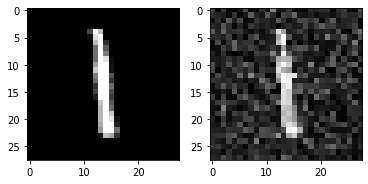

25  :  -0.6973993605569768 25
50  :  -0.6973993605569768 25
75  :  -0.5697052793518014 25
100  :  -0.5565125298430722 25
125  :  -0.5524927402880695 25
150  :  -0.5524927402880695 25
175  :  -0.5524927402880695 25
200  :  -0.5524927402880695 25
225  :  -0.5303834103969565 25
250  :  -0.5170661783401043 25
275  :  -0.5027080887146407 25
300  :  -0.49123082099798 25
325  :  -0.4835733756939823 25
350  :  -0.46010369185487 25
375  :  -0.46010369185487 25
400  :  -0.46010369185487 25
425  :  -0.46010369185487 25
450  :  -0.4473786120994604 25
475  :  -0.4471853017734817 25
500  :  -0.4471853017734817 25
525  :  -0.4471853017734817 25
550  :  -0.4471853017734817 25
575  :  -0.44536627617989144 25
600  :  -0.4307024664325354 25
625  :  -0.4241820353313017 25
650  :  -0.4241820353313017 25
675  :  -0.41925582642879045 25
700  :  -0.4176887091646384 25
725  :  -0.40936955442540934 25
750  :  -0.4085814492236979 25
775  :  -0.40432039696544797 25
800  :  -0.40432039696544797 25
825  :  -0.40405

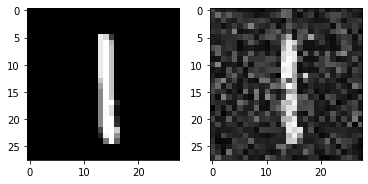

25  :  -0.6521621264986 25
50  :  -0.6521621264986 25
75  :  -0.6368342695097993 25
100  :  -0.6368342695097993 25
125  :  -0.5809674966358196 25
150  :  -0.5558211853035298 25
175  :  -0.5547104016132187 25
200  :  -0.550735229494969 25
225  :  -0.539970914589363 25
250  :  -0.5430398108136902 25
275  :  -0.5247326433234414 25
300  :  -0.5313334910460394 25
325  :  -0.5313334910460394 25
350  :  -0.5101857263170095 25
375  :  -0.5115361647426211 25
400  :  -0.44884814451528565 25
425  :  -0.43627685587092924 25
450  :  -0.4361026367756474 25
475  :  -0.4361026367756474 25
500  :  -0.4361026367756474 25
525  :  -0.4361026367756474 25
550  :  -0.4361026367756474 25
575  :  -0.4361026367756474 25
600  :  -0.4361026367756474 25
625  :  -0.4361026367756474 25
650  :  -0.4361026367756474 25
675  :  -0.4361026367756474 25
700  :  -0.4361026367756474 25
725  :  -0.4361026367756474 25
750  :  -0.4361026367756474 25
775  :  -0.4355148956364828 25
800  :  -0.4348697731242842 25
825  :  -0.434783

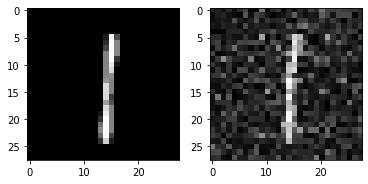

25  :  -0.6574387749983603 25
50  :  -0.6574387749983603 25
75  :  -0.6287625822593474 25
100  :  -0.6216927923410076 25
125  :  -0.6216927923410076 25
150  :  -0.6216927923410076 25
175  :  -0.6216927923410076 25
200  :  -0.578790383036742 25
225  :  -0.5720249427959423 25
250  :  -0.5638554827674842 25
275  :  -0.5624010147116028 25
300  :  -0.5624010147116028 25
325  :  -0.5510141685754855 25
350  :  -0.5315111917944593 25
375  :  -0.5238262811375096 25
400  :  -0.5238262811375096 25
425  :  -0.5194048420097963 25
450  :  -0.5191898007448019 25
475  :  -0.5163424112838244 25
500  :  -0.5110030640283402 25
525  :  -0.5108460516059764 25
550  :  -0.4864514718509588 25
575  :  -0.4864514718509588 25
600  :  -0.47707914264567264 25
625  :  -0.47660523710950764 25
650  :  -0.47660523710950764 25
675  :  -0.4765137942228569 25
700  :  -0.4765137942228569 25
725  :  -0.4765137942228569 25
750  :  -0.46387517160848935 25
775  :  -0.4461382020443678 25
800  :  -0.4461382020443678 25
825  :  

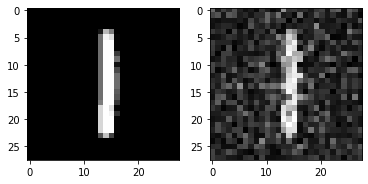

25  :  -0.6648995760901932 25
50  :  -0.6644427231310908 25
75  :  -0.6501621086945446 25
100  :  -0.625571985582515 25
125  :  -0.59951375116076 25
150  :  -0.6000663249919089 25
175  :  -0.6000663249919089 25
200  :  -0.5624375466796592 25
225  :  -0.5761175218576913 25
250  :  -0.5599355860931907 25
275  :  -0.5176689577296343 25
300  :  -0.5160412027573342 25
325  :  -0.5160412027573342 25
350  :  -0.5160412027573342 25
375  :  -0.5138330151672947 25
400  :  -0.5061012134891005 25
425  :  -0.5061663889461514 25
450  :  -0.5043505839791195 25
475  :  -0.5043505839791195 25
500  :  -0.5013298777366982 25
525  :  -0.49026456133077656 25
550  :  -0.49026456133077656 25
575  :  -0.486212458650223 25
600  :  -0.4760110138456789 25
625  :  -0.4753890682330011 25
650  :  -0.46654009558537823 25
675  :  -0.4578819190797455 25
700  :  -0.45880635478427034 25
725  :  -0.4516900091561158 25
750  :  -0.4516900091561158 25
775  :  -0.4516900091561158 25
800  :  -0.446584041986401 25
825  :  -0.4

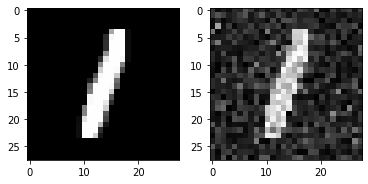

25  :  -0.6831679441281722 25
50  :  -0.6365648806256348 25
75  :  -0.6192036795007172 25
100  :  -0.5813878049098278 25
125  :  -0.5490651071764978 25
150  :  -0.5415718096334936 25
175  :  -0.5148040753647531 25
200  :  -0.4893681060441831 25
225  :  -0.46048812904229997 25
250  :  -0.4604828286014577 25
275  :  -0.4604828286014577 25
300  :  -0.4576940508996693 25
325  :  -0.4332398948696613 25
350  :  -0.42456026986302087 25
375  :  -0.4021152235900415 25
400  :  -0.4021152235900415 25
425  :  -0.3938579246473147 25
450  :  -0.3938579246473147 25
475  :  -0.3938579246473147 25
500  :  -0.3889774031690283 25
525  :  -0.3834193206326546 25
550  :  -0.37409482538289696 25
575  :  -0.3740954349409926 25
600  :  -0.3740954349409926 25
625  :  -0.3740954349409926 25
650  :  -0.3740954349409926 25
675  :  -0.3740954349409926 25
700  :  -0.3695149455122163 25
725  :  -0.36949958882778544 25
750  :  -0.36949958882778544 25
775  :  -0.36814693866079995 25
800  :  -0.36325000387564366 25
825 

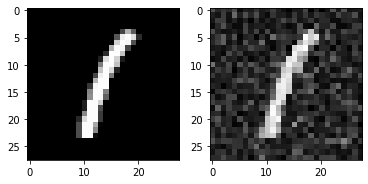

25  :  -0.7005169627865004 25
50  :  -0.595804741396234 25
75  :  -0.5768606451803049 25
100  :  -0.5768606451803049 25
125  :  -0.5768606451803049 25
150  :  -0.5768606451803049 25
175  :  -0.5768606451803049 25
200  :  -0.546669034023366 25
225  :  -0.5354919989440562 25
250  :  -0.4631346077044166 25
275  :  -0.4631346077044166 25
300  :  -0.45918741217212977 25
325  :  -0.4602269008150547 25
350  :  -0.4602269008150547 25
375  :  -0.4481750669615253 25
400  :  -0.4490790542398415 25
425  :  -0.435795566842452 25
450  :  -0.4338425034115966 25
475  :  -0.4338425034115966 25
500  :  -0.41935138286183726 25
525  :  -0.41935138286183726 25
550  :  -0.4114759506756055 25
575  :  -0.4098411252047556 25
600  :  -0.40939134383629516 25
625  :  -0.396442843960211 25
650  :  -0.3956951958028191 25
675  :  -0.3956951958028191 25
700  :  -0.39545730172394833 25
725  :  -0.39370579442861253 25
750  :  -0.39370579442861253 25
775  :  -0.3902370907859065 25
800  :  -0.390013223346136 25
825  :  -

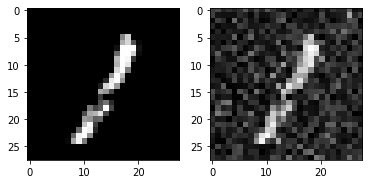

25  :  -0.7128494344754766 25
50  :  -0.6992023695747962 25
75  :  -0.6467571145973321 25
100  :  -0.5885825252861312 25
125  :  -0.549492446281526 25
150  :  -0.549492446281526 25
175  :  -0.549492446281526 25
200  :  -0.549492446281526 25
225  :  -0.5464662519507772 25
250  :  -0.5368799120196999 25
275  :  -0.5251810533579195 25
300  :  -0.5037042299853194 25
325  :  -0.4903960529659852 25
350  :  -0.4886433721378177 25
375  :  -0.48736328020650066 25
400  :  -0.48830175739064396 25
425  :  -0.48594620112212195 25
450  :  -0.46454466819529316 25
475  :  -0.46454466819529316 25
500  :  -0.46454466819529316 25
525  :  -0.44827341053155423 25
550  :  -0.44830653120874386 25
575  :  -0.43700326377746135 25
600  :  -0.4370324960996367 25
625  :  -0.4370324960996367 25
650  :  -0.4370324960996367 25
675  :  -0.4370324960996367 25
700  :  -0.42907109097726326 25
725  :  -0.41881936447487933 25
750  :  -0.4102103357671587 25
775  :  -0.40997380465411803 25
800  :  -0.40904383998405025 25
82

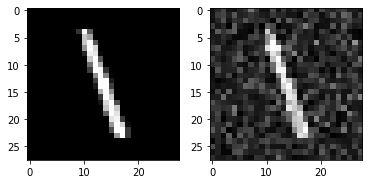

25  :  -0.7052049144344819 25
50  :  -0.6151393940419385 25
75  :  -0.6291120663977745 25
100  :  -0.612372726833049 25
125  :  -0.5464940619192844 25
150  :  -0.5464940619192844 25
175  :  -0.5464940619192844 25
200  :  -0.5464940619192844 25
225  :  -0.5464940619192844 25
250  :  -0.5384255781393883 25
275  :  -0.5384255781393883 25
300  :  -0.5313308682370856 25
325  :  -0.5301387576179108 25
350  :  -0.5248330442058908 25
375  :  -0.5072697400165883 25
400  :  -0.510920850873886 25
425  :  -0.5030189632278677 25
450  :  -0.49318661476821635 25
475  :  -0.4866308873234735 25
500  :  -0.4740372998829262 25
525  :  -0.46543853612059394 25
550  :  -0.46624714215552476 25
575  :  -0.4642603966215346 25
600  :  -0.45346769212994154 25
625  :  -0.45346769212994154 25
650  :  -0.45107049813398503 25
675  :  -0.43453070065419896 25
700  :  -0.4347161947556739 25
725  :  -0.4347161947556739 25
750  :  -0.4318903728908463 25
775  :  -0.42442803506273996 25
800  :  -0.4244045956527783 25
825  

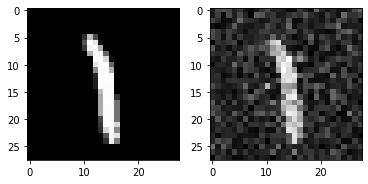

25  :  -0.6019815822399868 25
50  :  -0.6019815822399868 25
75  :  -0.6019815822399868 25
100  :  -0.6019815822399868 25
125  :  -0.6019815822399868 25
150  :  -0.6019815822399868 25
175  :  -0.5838610568833089 25
200  :  -0.5644961325613862 25
225  :  -0.5574287894549299 25
250  :  -0.5352405278241947 25
275  :  -0.49278597616954267 25
300  :  -0.4909926192381907 25
325  :  -0.4909926192381907 25
350  :  -0.4909926192381907 25
375  :  -0.4909926192381907 25
400  :  -0.4909926192381907 25
425  :  -0.4909926192381907 25
450  :  -0.48182262247991237 25
475  :  -0.476202773229364 25
500  :  -0.47598698387172567 25
525  :  -0.4694662878805611 25
550  :  -0.464033876030842 25
575  :  -0.4650165827345015 25
600  :  -0.4650165827345015 25
625  :  -0.4532190071479355 25
650  :  -0.45018610722576213 25
675  :  -0.44739025294423407 25
700  :  -0.4485264292549843 25
725  :  -0.4472186609787062 25
750  :  -0.4434335300566037 25
775  :  -0.4435831080853119 25
800  :  -0.44279537845849326 25
825  : 

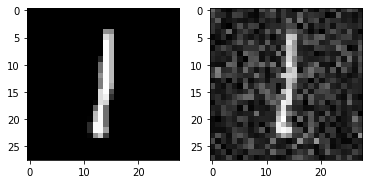

25  :  -0.691169011391032 25
50  :  -0.6791049806817777 25
75  :  -0.6271436738258289 25
100  :  -0.6171902187077154 25
125  :  -0.6171902187077154 25
150  :  -0.5873487765485457 25
175  :  -0.5873487765485457 25
200  :  -0.5873487765485457 25
225  :  -0.5684863509405351 25
250  :  -0.5478199555786434 25
275  :  -0.5445193165598887 25
300  :  -0.5138481838680773 25
325  :  -0.513390249226714 25
350  :  -0.4989518467756071 25
375  :  -0.4989518467756071 25
400  :  -0.4989518467756071 25
425  :  -0.4966219301440793 25
450  :  -0.4969835087772789 25
475  :  -0.4969835087772789 25
500  :  -0.4839254571612508 25
525  :  -0.4516787069754188 25
550  :  -0.4452157096520968 25
575  :  -0.4452157096520968 25
600  :  -0.4428166829225374 25
625  :  -0.438498164909188 25
650  :  -0.43840250063544683 25
675  :  -0.43537705948098226 25
700  :  -0.42311330071271935 25
725  :  -0.42311330071271935 25
750  :  -0.42311330071271935 25
775  :  -0.42311330071271935 25
800  :  -0.42311330071271935 25
825  : 

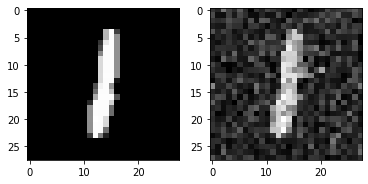

25  :  -0.652604302884181 25
50  :  -0.6377452136296182 25
75  :  -0.6374168378405325 25
100  :  -0.6230099582667199 25
125  :  -0.5979749304814859 25
150  :  -0.5582062014391198 25
175  :  -0.5685950643922539 25
200  :  -0.5633656619175942 25
225  :  -0.5470328444576674 25
250  :  -0.5279499589134247 25
275  :  -0.5217032675888629 25
300  :  -0.5158556561653969 25
325  :  -0.514349801006061 25
350  :  -0.48649473460455983 25
375  :  -0.44809686307821495 25
400  :  -0.44759241325662147 25
425  :  -0.44112690931782106 25
450  :  -0.4468912134084243 25
475  :  -0.43800646527098763 25
500  :  -0.4394921837459065 25
525  :  -0.4394921837459065 25
550  :  -0.4394921837459065 25
575  :  -0.43674422466674645 25
600  :  -0.43674422466674645 25
625  :  -0.43674422466674645 25
650  :  -0.43674422466674645 25
675  :  -0.43674422466674645 25
700  :  -0.43674422466674645 25
725  :  -0.43674422466674645 25
750  :  -0.4248196816669193 25
775  :  -0.42489220895189983 25
800  :  -0.42489220895189983 25

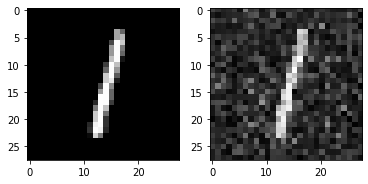

25  :  -0.7035022835716342 25
50  :  -0.6424803886157002 25
75  :  -0.642493067875556 25
100  :  -0.5708597176778796 25
125  :  -0.5650900906036513 25
150  :  -0.5650900906036513 25
175  :  -0.5650900906036513 25
200  :  -0.5343705328785364 25
225  :  -0.5340369650225314 25
250  :  -0.5340369650225314 25
275  :  -0.5181471415634686 25
300  :  -0.5181471415634686 25
325  :  -0.5181471415634686 25
350  :  -0.5181471415634686 25
375  :  -0.49213428654277547 25
400  :  -0.49213428654277547 25
425  :  -0.49213428654277547 25
450  :  -0.481714752991642 25
475  :  -0.47687882037839424 25
500  :  -0.47687882037839424 25
525  :  -0.4559778683331297 25
550  :  -0.4559778683331297 25
575  :  -0.4559778683331297 25
600  :  -0.44460066547597454 25
625  :  -0.4438897441572186 25
650  :  -0.4449596290158926 25
675  :  -0.4413383025592016 25
700  :  -0.4349505337992875 25
725  :  -0.4315436902574087 25
750  :  -0.4314550759663184 25
775  :  -0.42191277787623793 25
800  :  -0.42191277787623793 25
825  

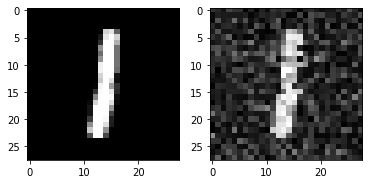

25  :  -0.6167585949443906 25
50  :  -0.6167585949443906 25
75  :  -0.6100841940824522 25
100  :  -0.5936063704041528 25
125  :  -0.5635368410816604 25
150  :  -0.5515570246357575 25
175  :  -0.5362846853691696 25
200  :  -0.5100971251386184 25
225  :  -0.500887895177687 25
250  :  -0.4742886930572128 25
275  :  -0.47432390407368774 25
300  :  -0.47046651554255314 25
325  :  -0.4581898651015526 25
350  :  -0.4524456481464413 25
375  :  -0.4524456481464413 25
400  :  -0.4489330693549509 25
425  :  -0.4397072098265865 25
450  :  -0.4330854028065122 25
475  :  -0.3925573210168041 25
500  :  -0.39142632601752414 25
525  :  -0.38970155775411597 25
550  :  -0.38901403652286215 25
575  :  -0.38901403652286215 25
600  :  -0.3880080556383685 25
625  :  -0.3856971916216405 25
650  :  -0.37824885248910634 25
675  :  -0.37586716406340404 25
700  :  -0.36384246847145496 25
725  :  -0.36388485060181697 25
750  :  -0.36331514885507343 25
775  :  -0.36096650484641757 25
800  :  -0.3569397672776462 25


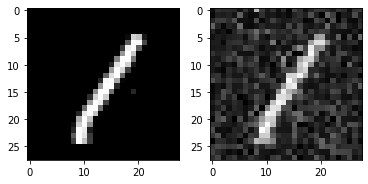

25  :  -0.7078467115318272 25
50  :  -0.6504462518668919 25
75  :  -0.6504462518668919 25
100  :  -0.6504462518668919 25
125  :  -0.5266873385377249 25
150  :  -0.5286690562675072 25
175  :  -0.5286690562675072 25
200  :  -0.5101833314680319 25
225  :  -0.5071437594959383 25
250  :  -0.506526745900797 25
275  :  -0.506526745900797 25
300  :  -0.506526745900797 25
325  :  -0.506526745900797 25
350  :  -0.506526745900797 25
375  :  -0.506526745900797 25
400  :  -0.506526745900797 25
425  :  -0.5031462600026667 25
450  :  -0.4825280070449647 25
475  :  -0.47887308636254733 25
500  :  -0.47887308636254733 25
525  :  -0.47887308636254733 25
550  :  -0.4774131034895106 25
575  :  -0.47887308636254733 25
600  :  -0.47577476642495575 25
625  :  -0.4695854416731946 25
650  :  -0.4689337693408536 25
675  :  -0.4689337693408536 25
700  :  -0.4607492792010115 25
725  :  -0.45042840749580315 25
750  :  -0.4445498156585761 25
775  :  -0.43955271609828384 25
800  :  -0.43915323388931793 25
825  :  -0

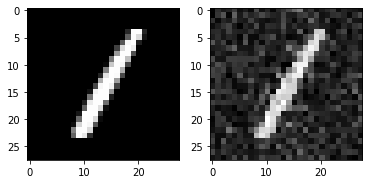

25  :  -1.6845621811727178 25
50  :  -1.5886426874671127 25
75  :  -1.5212585401366323 25
100  :  -1.5212585401366323 25
125  :  -1.5038820687937986 25
150  :  -1.4893783500982258 25
175  :  -1.4529048031951428 25
200  :  -1.4514103715141298 25
225  :  -1.401523404914875 25
250  :  -1.401523404914875 25
275  :  -1.3935126747802737 25
300  :  -1.3935126747802737 25
325  :  -1.389839321860618 25
350  :  -1.3739388737711014 25
375  :  -1.3640143444749162 25
400  :  -1.3609308770360031 25
425  :  -1.3560458203353112 25
450  :  -1.3544137189298757 25
475  :  -1.3520663325765387 25
500  :  -1.3520663325765387 25
525  :  -1.35085148627727 25
550  :  -1.3492873986859264 25
575  :  -1.341844592611145 25
600  :  -1.336895641354308 25
625  :  -1.3329128151000262 25
650  :  -1.3329128151000262 25
675  :  -1.3296165992131341 25
700  :  -1.3296165992131341 25
725  :  -1.3291514011624086 25
750  :  -1.327764030735982 25
775  :  -1.32729416531398 25
800  :  -1.3271542814286543 25
825  :  -1.3251428868

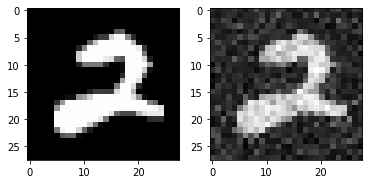

25  :  -1.6373319698792252 25
50  :  -1.6186503845000795 25
75  :  -1.5831062400872462 25
100  :  -1.5153213117339346 25
125  :  -1.4913014320342508 25
150  :  -1.4588712305048646 25
175  :  -1.4551280781734603 25
200  :  -1.4293757735537822 25
225  :  -1.4293757735537822 25
250  :  -1.404168203898084 25
275  :  -1.3899790797082303 25
300  :  -1.368015219828562 25
325  :  -1.3678306286324347 25
350  :  -1.3620651101861103 25
375  :  -1.3620651101861103 25
400  :  -1.3616163641756704 25
425  :  -1.3590573910661838 25
450  :  -1.338746147937469 25
475  :  -1.3387027795396904 25
500  :  -1.3234331601193396 25
525  :  -1.3234331601193396 25
550  :  -1.3234331601193396 25
575  :  -1.3234331601193396 25
600  :  -1.322559224163704 25
625  :  -1.3211997490276555 25
650  :  -1.3123439927251943 25
675  :  -1.3116949380404228 25
700  :  -1.3116949380404228 25
725  :  -1.3116949380404228 25
750  :  -1.306682757428743 25
775  :  -1.3054656580528925 25
800  :  -1.3051801670201333 25
825  :  -1.30512

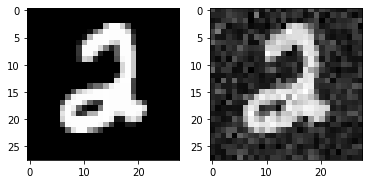

25  :  -1.6118442652062852 25
50  :  -1.6118442652062852 25
75  :  -1.5991266139020428 25
100  :  -1.543222991850679 25
125  :  -1.5249685458776203 25
150  :  -1.5043645471463978 25
175  :  -1.4820740225744187 25
200  :  -1.4510517944487131 25
225  :  -1.4496321828685137 25
250  :  -1.4315624005958871 25
275  :  -1.4205671516214404 25
300  :  -1.396333496683243 25
325  :  -1.3958435904103186 25
350  :  -1.3855582918256775 25
375  :  -1.367135448805072 25
400  :  -1.3527472479646514 25
425  :  -1.3509604155690327 25
450  :  -1.3467790340564934 25
475  :  -1.3392941373015068 25
500  :  -1.3348984793788228 25
525  :  -1.3345799656345743 25
550  :  -1.3337337151710495 25
575  :  -1.3274197911466803 25
600  :  -1.3261703762508952 25
625  :  -1.3225139188953392 25
650  :  -1.321510909138138 25
675  :  -1.3176329853305526 25
700  :  -1.3176329853305526 25
725  :  -1.3168542036279363 25
750  :  -1.3162928891383663 25
775  :  -1.3144312047990812 25
800  :  -1.313319373254541 25
825  :  -1.31271

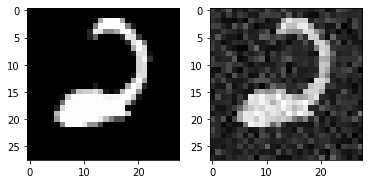

25  :  -0.8561729958813833 25
50  :  -0.6966363891187031 25
75  :  -0.6943316315489172 25
100  :  -0.6491814431494014 25
125  :  -0.6362072706677142 25
150  :  -0.6325271990541852 25
175  :  -0.6325271990541852 25
200  :  -0.6325271990541852 25
225  :  -0.5755551699579127 25
250  :  -0.5755551699579127 25
275  :  -0.5755551699579127 25
300  :  -0.572616832660424 25
325  :  -0.5606845531708358 25
350  :  -0.5606845531708358 25
375  :  -0.5586128129555497 25
400  :  -0.5406792596009014 25
425  :  -0.5307598479529945 25
450  :  -0.5307598479529945 25
475  :  -0.5307598479529945 25
500  :  -0.5229346936543298 25
525  :  -0.516430905329264 25
550  :  -0.5152657917838737 25
575  :  -0.5084135892801124 25
600  :  -0.5088375874723646 25
625  :  -0.5084291147888125 25
650  :  -0.5017289228145784 25
675  :  -0.4990559915917089 25
700  :  -0.4969619086244027 25
725  :  -0.49486231538346503 25
750  :  -0.4905443793970585 25
775  :  -0.4880325123259657 25
800  :  -0.4880325123259657 25
825  :  -0.4

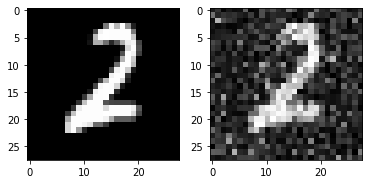

25  :  -0.8125751949794116 25
50  :  -0.8125751949794116 25
75  :  -0.8125751949794116 25
100  :  -0.8125751949794116 25
125  :  -0.8125751949794116 25
150  :  -0.8125751949794116 25
175  :  -0.8125751949794116 25
200  :  -0.8125751949794116 25
225  :  -0.802216407159152 25
250  :  -0.7989260121549098 25
275  :  -0.794784033793803 25
300  :  -0.7538867144142203 25
325  :  -0.7517555550859136 25
350  :  -0.7423991612231442 25
375  :  -0.7423991612231442 25
400  :  -0.7229958182636533 25
425  :  -0.7142640527278936 25
450  :  -0.7099273809244446 25
475  :  -0.7099273809244446 25
500  :  -0.7099273809244446 25
525  :  -0.7010593984587645 25
550  :  -0.6977927430583934 25
575  :  -0.6953206854215828 25
600  :  -0.6798510669713695 25
625  :  -0.6596453972884828 25
650  :  -0.6596453972884828 25
675  :  -0.6596453972884828 25
700  :  -0.6546743948946874 25
725  :  -0.6406115262439449 25
750  :  -0.6406115262439449 25
775  :  -0.6406115262439449 25
800  :  -0.6335130051809057 25
825  :  -0.63

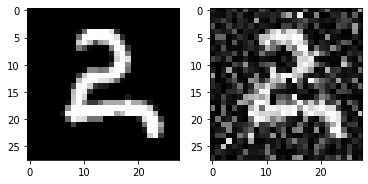

25  :  -0.8842237838029412 25
50  :  -0.8608966844585166 25
75  :  -0.7486429807614368 25
100  :  -0.7454741000887086 25
125  :  -0.7312916122200348 25
150  :  -0.7312916122200348 25
175  :  -0.6897068937364206 25
200  :  -0.6897068937364206 25
225  :  -0.6897068937364206 25
250  :  -0.6897068937364206 25
275  :  -0.6897068937364206 25
300  :  -0.6897068937364206 25
325  :  -0.6822470886072469 25
350  :  -0.6270331248970766 25
375  :  -0.6040794345610687 25
400  :  -0.6034393812058241 25
425  :  -0.6034393812058241 25
450  :  -0.5876750345543937 25
475  :  -0.5773919418245523 25
500  :  -0.5697826282997476 25
525  :  -0.5613704740709013 25
550  :  -0.5286028658807853 25
575  :  -0.5284975349645822 25
600  :  -0.5223966102517115 25
625  :  -0.5224470022226495 25
650  :  -0.5083356432662643 25
675  :  -0.5072534792324981 25
700  :  -0.49716879275307235 25
725  :  -0.49744403982563923 25
750  :  -0.4962515197570023 25
775  :  -0.48931798212098754 25
800  :  -0.487758779316682 25
825  :  -

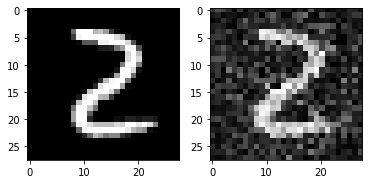

25  :  -0.7803016226830197 25
50  :  -0.7803016226830197 25
75  :  -0.7485539680199438 25
100  :  -0.7485539680199438 25
125  :  -0.7485539680199438 25
150  :  -0.7485539680199438 25
175  :  -0.7485539680199438 25
200  :  -0.7485539680199438 25
225  :  -0.7485539680199438 25
250  :  -0.7252195651985804 25
275  :  -0.7252195651985804 25
300  :  -0.7053005939010133 25
325  :  -0.7053005939010133 25
350  :  -0.6915797107677659 25
375  :  -0.6451228304339307 25
400  :  -0.6329566358676864 25
425  :  -0.6044006156894586 25
450  :  -0.6036671120469457 25
475  :  -0.5773342738614513 25
500  :  -0.5776006565475507 25
525  :  -0.5776006565475507 25
550  :  -0.5696726332802873 25
575  :  -0.5696726332802873 25
600  :  -0.5385667370923735 25
625  :  -0.5385667370923735 25
650  :  -0.5385667370923735 25
675  :  -0.5385667370923735 25
700  :  -0.5385667370923735 25
725  :  -0.5385667370923735 25
750  :  -0.5376122572598787 25
775  :  -0.5376122572598787 25
800  :  -0.5204671870016186 25
825  :  -0.

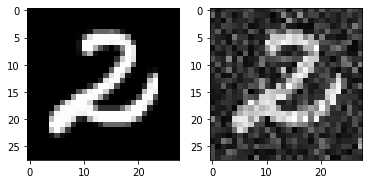

25  :  -1.0703386748747459 25
50  :  -0.7419722587868147 25
75  :  -0.751527126323118 25
100  :  -0.751527126323118 25
125  :  -0.751527126323118 25
150  :  -0.751527126323118 25
175  :  -0.751527126323118 25
200  :  -0.751527126323118 25
225  :  -0.751527126323118 25
250  :  -0.751527126323118 25
275  :  -0.751527126323118 25
300  :  -0.751527126323118 25
325  :  -0.751527126323118 25
350  :  -0.751527126323118 25
375  :  -0.751527126323118 25
400  :  -0.7164672476010758 25
425  :  -0.7164672476010758 25
450  :  -0.7164672476010758 25
475  :  -0.7164672476010758 25
500  :  -0.6974552309391144 25
525  :  -0.6778127564905339 25
550  :  -0.6623095316206433 25
575  :  -0.6632698977797613 25
600  :  -0.6632698977797613 25
625  :  -0.6476252948396348 25
650  :  -0.6476252948396348 25
675  :  -0.6313839771398537 25
700  :  -0.6278597261947196 25
725  :  -0.6282736556030362 25
750  :  -0.6282736556030362 25
775  :  -0.6282736556030362 25
800  :  -0.6282736556030362 25
825  :  -0.6255139207896

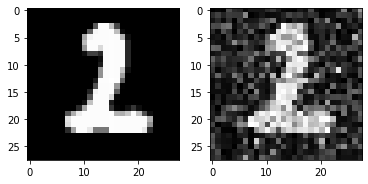

25  :  -0.9902911464661843 25
50  :  -0.8916778812101325 25
75  :  -0.853514829384231 25
100  :  -0.853514829384231 25
125  :  -0.853514829384231 25
150  :  -0.8448160678351027 25
175  :  -0.8183692948018062 25
200  :  -0.8057045439367714 25
225  :  -0.7751482305332573 25
250  :  -0.7751482305332573 25
275  :  -0.7657744054930911 25
300  :  -0.6738665797546746 25
325  :  -0.6738665797546746 25
350  :  -0.6738665797546746 25
375  :  -0.6738665797546746 25
400  :  -0.6606385955171932 25
425  :  -0.6522602797330397 25
450  :  -0.6522602797330397 25
475  :  -0.6522602797330397 25
500  :  -0.6522602797330397 25
525  :  -0.6522602797330397 25
550  :  -0.6522602797330397 25
575  :  -0.6445896089595842 25
600  :  -0.6379193376102805 25
625  :  -0.6381056332635087 25
650  :  -0.6381056332635087 25
675  :  -0.6241029446262061 25
700  :  -0.6239768678551612 25
725  :  -0.6239768678551612 25
750  :  -0.6162372100228517 25
775  :  -0.5981803514363704 25
800  :  -0.5981803514363704 25
825  :  -0.598

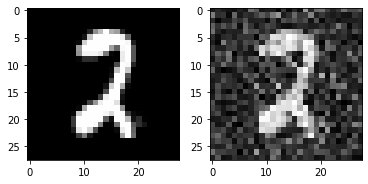

25  :  -1.6574080902335564 25
50  :  -1.588956134526286 25
75  :  -1.532200216882991 25
100  :  -1.5249000483165656 25
125  :  -1.4895804710765463 25
150  :  -1.4165416310411911 25
175  :  -1.4231317160225145 25
200  :  -1.312538664959497 25
225  :  -1.260845884391029 25
250  :  -1.1760513022889028 25
275  :  -1.1760513022889028 25
300  :  -1.1760513022889028 25
325  :  -1.1760513022889028 25
350  :  -0.962564155611912 25
375  :  -1.0381452461300995 25
400  :  -1.0381452461300995 25
425  :  -1.0381452461300995 25
450  :  -1.0381452461300995 25
475  :  -1.0381452461300995 25
500  :  -1.0145236302543919 25
525  :  -0.9223287181152828 25
550  :  -0.926575036978978 25
575  :  -0.9072931926829433 25
600  :  -0.9037672938683095 25
625  :  -0.9037672938683095 25
650  :  -0.9037672938683095 25
675  :  -0.9037672938683095 25
700  :  -0.9037672938683095 25
725  :  -0.9037672938683095 25
750  :  -0.9037672938683095 25
775  :  -0.9037672938683095 25
800  :  -0.9037672938683095 25
825  :  -0.903767

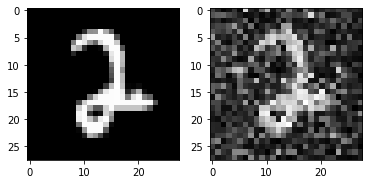

25  :  -1.2197390418737724 25
50  :  -1.1078187933344805 25
75  :  -0.954391313325657 25
100  :  -1.0325909841444938 25
125  :  -0.9697769125908273 25
150  :  -0.942239230519432 25
175  :  -0.938125576148364 25
200  :  -0.938125576148364 25
225  :  -0.8481703801163039 25
250  :  -0.7891400370147728 25
275  :  -0.7982785824332361 25
300  :  -0.7982785824332361 25
325  :  -0.7982785824332361 25
350  :  -0.7982785824332361 25
375  :  -0.7982785824332361 25
400  :  -0.7915980449099154 25
425  :  -0.7894178743374192 25
450  :  -0.7746480107000853 25
475  :  -0.7510899430420632 25
500  :  -0.7129278345363206 25
525  :  -0.7129278345363206 25
550  :  -0.7129278345363206 25
575  :  -0.7129278345363206 25
600  :  -0.7129278345363206 25
625  :  -0.6990007276429293 25
650  :  -0.698999321916201 25
675  :  -0.6918482266796713 25
700  :  -0.6801320234935264 25
725  :  -0.6720191256269694 25
750  :  -0.6621086637280733 25
775  :  -0.6521431795485606 25
800  :  -0.6383077596526769 25
825  :  -0.63823

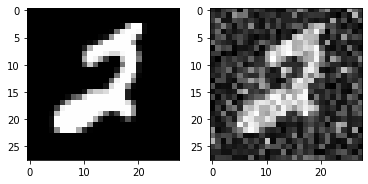

25  :  -1.4451447253763825 25
50  :  -1.4451447253763825 25
75  :  -1.4965661255286504 25
100  :  -1.3634986671897307 25
125  :  -1.1243563404931791 25
150  :  -1.0658351014221183 25
175  :  -1.083614627540143 25
200  :  -1.0441047854322407 25
225  :  -1.037213161979545 25
250  :  -0.8447061817842287 25
275  :  -0.867340410469992 25
300  :  -0.867340410469992 25
325  :  -0.867340410469992 25
350  :  -0.867340410469992 25
375  :  -0.8136865014015595 25
400  :  -0.8136642587832996 25
425  :  -0.8136642587832996 25
450  :  -0.8136642587832996 25
475  :  -0.7957321095294212 25
500  :  -0.7964371686035989 25
525  :  -0.7841579440117881 25
550  :  -0.7816706335373087 25
575  :  -0.7639737100537476 25
600  :  -0.7600093474436096 25
625  :  -0.7553419545288735 25
650  :  -0.7547951536105086 25
675  :  -0.7462062691967071 25
700  :  -0.739952830999465 25
725  :  -0.7362761202569443 25
750  :  -0.7366637860973542 25
775  :  -0.7286340725903806 25
800  :  -0.7287244123561709 25
825  :  -0.7255805

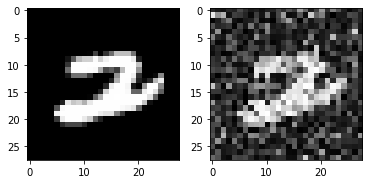

25  :  -0.6881176028947629 25
50  :  -0.6642755757141665 25
75  :  -0.6437640192952752 25
100  :  -0.6222334044359725 25
125  :  -0.6222334044359725 25
150  :  -0.5579337575300676 25
175  :  -0.5398698217816063 25
200  :  -0.49849204332717867 25
225  :  -0.49849204332717867 25
250  :  -0.49849204332717867 25
275  :  -0.49849204332717867 25
300  :  -0.49849204332717867 25
325  :  -0.4807162742732184 25
350  :  -0.47870606064111454 25
375  :  -0.4630747533619516 25
400  :  -0.4495924084891031 25
425  :  -0.44898270044250677 25
450  :  -0.4443106336917413 25
475  :  -0.43493707875826304 25
500  :  -0.4234542196653388 25
525  :  -0.4234542196653388 25
550  :  -0.41902955490575255 25
575  :  -0.4112647557164554 25
600  :  -0.4046150685954344 25
625  :  -0.40334383583396216 25
650  :  -0.3947184256727222 25
675  :  -0.39423950601399493 25
700  :  -0.39006519634952597 25
725  :  -0.39006519634952597 25
750  :  -0.3885830674847903 25
775  :  -0.38557233725127993 25
800  :  -0.3829309226519294 

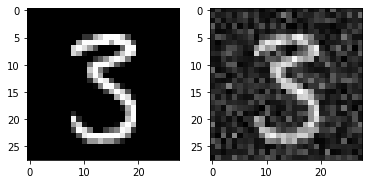

25  :  -0.8001256737466271 25
50  :  -0.8001256737466271 25
75  :  -0.7636636621381094 25
100  :  -0.7276622959890109 25
125  :  -0.7417376150129029 25
150  :  -0.7290097202668326 25
175  :  -0.7242945125089548 25
200  :  -0.6968830110703281 25
225  :  -0.6778700497677492 25
250  :  -0.675673606224743 25
275  :  -0.654655397187129 25
300  :  -0.6294514416260724 25
325  :  -0.6292268013259481 25
350  :  -0.6176869349803906 25
375  :  -0.6176869349803906 25
400  :  -0.585522939568144 25
425  :  -0.585522939568144 25
450  :  -0.5813785684825281 25
475  :  -0.5810626587369925 25
500  :  -0.5810626587369925 25
525  :  -0.5730484176683177 25
550  :  -0.5653824365655886 25
575  :  -0.5654442032167255 25
600  :  -0.5654442032167255 25
625  :  -0.5528745809094038 25
650  :  -0.552873134827897 25
675  :  -0.5528225396831372 25
700  :  -0.5466185173233473 25
725  :  -0.5466185173233473 25
750  :  -0.5461347354156916 25
775  :  -0.5456926867305563 25
800  :  -0.540128496045265 25
825  :  -0.539765

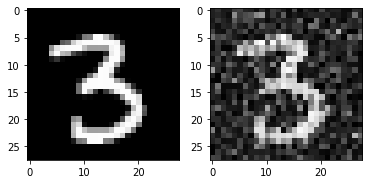

25  :  -0.745566607214887 25
50  :  -0.745566607214887 25
75  :  -0.7189012337201488 25
100  :  -0.7189012337201488 25
125  :  -0.7189012337201488 25
150  :  -0.7189012337201488 25
175  :  -0.6407833516752226 25
200  :  -0.6339479784576934 25
225  :  -0.6240436305910202 25
250  :  -0.6240436305910202 25
275  :  -0.53933078888682 25
300  :  -0.5389726990702806 25
325  :  -0.5335047007376077 25
350  :  -0.5129491465547122 25
375  :  -0.5132204105294556 25
400  :  -0.5132204105294556 25
425  :  -0.5132204105294556 25
450  :  -0.5066160370022168 25
475  :  -0.49055833474344124 25
500  :  -0.4811275107786851 25
525  :  -0.4811275107786851 25
550  :  -0.4811275107786851 25
575  :  -0.4800261657194901 25
600  :  -0.4750964241930896 25
625  :  -0.46436506159351376 25
650  :  -0.46436506159351376 25
675  :  -0.46436506159351376 25
700  :  -0.46436506159351376 25
725  :  -0.46176662219860376 25
750  :  -0.4587439802864067 25
775  :  -0.457288558373638 25
800  :  -0.4559791158986135 25
825  :  -0

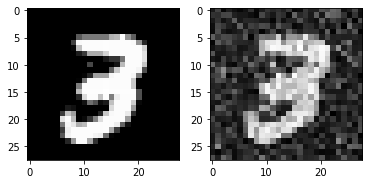

25  :  -0.7542304155761572 25
50  :  -0.7542304155761572 25
75  :  -0.7156132721557875 25
100  :  -0.6565060190421739 25
125  :  -0.636089862770449 25
150  :  -0.636089862770449 25
175  :  -0.636089862770449 25
200  :  -0.636089862770449 25
225  :  -0.6057141429384938 25
250  :  -0.5867626512706321 25
275  :  -0.5867626512706321 25
300  :  -0.5564157087961663 25
325  :  -0.5564157087961663 25
350  :  -0.5564157087961663 25
375  :  -0.5354295163953151 25
400  :  -0.527571642587142 25
425  :  -0.5275833514730364 25
450  :  -0.5275833514730364 25
475  :  -0.509899991866032 25
500  :  -0.5017235714592484 25
525  :  -0.4949432940231081 25
550  :  -0.4914048027066287 25
575  :  -0.4914048027066287 25
600  :  -0.4914048027066287 25
625  :  -0.4810530363151515 25
650  :  -0.4811469719811532 25
675  :  -0.4811469719811532 25
700  :  -0.4727737390537763 25
725  :  -0.4707128542386839 25
750  :  -0.47069433018063245 25
775  :  -0.4649631942173499 25
800  :  -0.4604643104144104 25
825  :  -0.46045

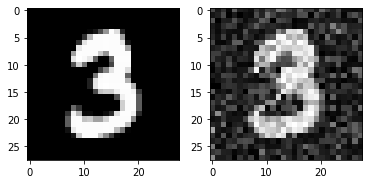

25  :  -0.8753722850215635 25
50  :  -0.8250699432717901 25
75  :  -0.7135997294984593 25
100  :  -0.7149956640563853 25
125  :  -0.7149956640563853 25
150  :  -0.7149956640563853 25
175  :  -0.7019587890973609 25
200  :  -0.7019587890973609 25
225  :  -0.6327759234549852 25
250  :  -0.6317763934321847 25
275  :  -0.6317763934321847 25
300  :  -0.6317763934321847 25
325  :  -0.6317763934321847 25
350  :  -0.6116419217805635 25
375  :  -0.6116419217805635 25
400  :  -0.6116419217805635 25
425  :  -0.6116419217805635 25
450  :  -0.6108185442130871 25
475  :  -0.5779762779386026 25
500  :  -0.5779762779386026 25
525  :  -0.5641445586870981 25
550  :  -0.5647442303651067 25
575  :  -0.5647442303651067 25
600  :  -0.5647442303651067 25
625  :  -0.5647442303651067 25
650  :  -0.5551983377432832 25
675  :  -0.5552269433968129 25
700  :  -0.5505260317002232 25
725  :  -0.5505260317002232 25
750  :  -0.5409059583351701 25
775  :  -0.5371533604045868 25
800  :  -0.5371533604045868 25
825  :  -0.

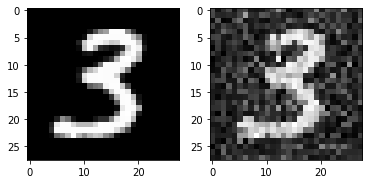

25  :  -0.9942005233256228 25
50  :  -0.9942005233256228 25
75  :  -1.1115244529365544 25
100  :  -1.0561209114232897 25
125  :  -1.0561209114232897 25
150  :  -0.9898647089954258 25
175  :  -0.8303492590209285 25
200  :  -0.8879741222316839 25
225  :  -0.8879741222316839 25
250  :  -0.8686950380328948 25
275  :  -0.8134499077074531 25
300  :  -0.8134499077074531 25
325  :  -0.8134499077074531 25
350  :  -0.7944592799495322 25
375  :  -0.7946572078586964 25
400  :  -0.7723190321769482 25
425  :  -0.7692648477306874 25
450  :  -0.7623430864695429 25
475  :  -0.7377610553440512 25
500  :  -0.7342498228514054 25
525  :  -0.7341477362828479 25
550  :  -0.7328591641201325 25
575  :  -0.7328591641201325 25
600  :  -0.7144229540358085 25
625  :  -0.7077775216928843 25
650  :  -0.7038936626367931 25
675  :  -0.7015264458628159 25
700  :  -0.6987974383026987 25
725  :  -0.6856225602076369 25
750  :  -0.6739474452988206 25
775  :  -0.6739474452988206 25
800  :  -0.6679597801170447 25
825  :  -0.

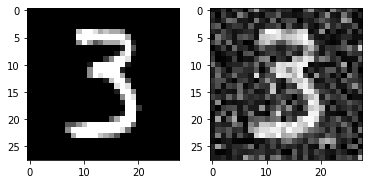

25  :  -1.0414011003047783 25
50  :  -1.0414011003047783 25
75  :  -0.8951811536262095 25
100  :  -0.8951811536262095 25
125  :  -0.8951811536262095 25
150  :  -0.8308995205922947 25
175  :  -0.8308995205922947 25
200  :  -0.8308995205922947 25
225  :  -0.8308995205922947 25
250  :  -0.8018335525976921 25
275  :  -0.8017756327221588 25
300  :  -0.7591581570016603 25
325  :  -0.7591581570016603 25
350  :  -0.7591581570016603 25
375  :  -0.7551939434828063 25
400  :  -0.7116400848386375 25
425  :  -0.7126267687903458 25
450  :  -0.7126267687903458 25
475  :  -0.6878347981507225 25
500  :  -0.6877661481711295 25
525  :  -0.6874305124568885 25
550  :  -0.6874305124568885 25
575  :  -0.6803662042493068 25
600  :  -0.6803662042493068 25
625  :  -0.6803662042493068 25
650  :  -0.6766938651681433 25
675  :  -0.6566819197217075 25
700  :  -0.6493527743547658 25
725  :  -0.6493527743547658 25
750  :  -0.6493527743547658 25
775  :  -0.6479659037918426 25
800  :  -0.6479659037918426 25
825  :  -0.

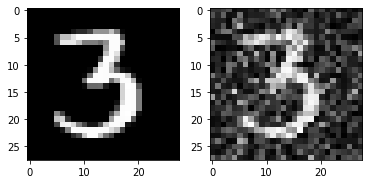

25  :  -1.6560256268055296 25
50  :  -1.0020463894683675 25
75  :  -1.1324873755264409 25
100  :  -0.8507108638069589 25
125  :  -0.8636209963396388 25
150  :  -0.8233791863906239 25
175  :  -0.8182114832035909 25
200  :  -0.7972896514858878 25
225  :  -0.7972896514858878 25
250  :  -0.7954257913646248 25
275  :  -0.7972896514858878 25
300  :  -0.7972896514858878 25
325  :  -0.7844043751417296 25
350  :  -0.7769533583702437 25
375  :  -0.7574304334536981 25
400  :  -0.7505324774822872 25
425  :  -0.749142341372266 25
450  :  -0.7371054128419969 25
475  :  -0.7354198606965954 25
500  :  -0.7175254931158035 25
525  :  -0.7176425041651471 25
550  :  -0.7176425041651471 25
575  :  -0.7144086702180035 25
600  :  -0.6843630197257626 25
625  :  -0.6843488034692948 25
650  :  -0.6843488034692948 25
675  :  -0.6718558253550362 25
700  :  -0.6718558253550362 25
725  :  -0.6718558253550362 25
750  :  -0.6718558253550362 25
775  :  -0.6718558253550362 25
800  :  -0.6718558253550362 25
825  :  -0.6

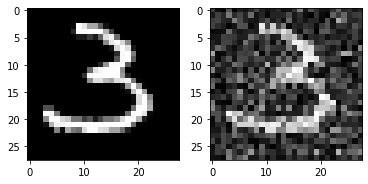

25  :  -1.119742249363277 25
50  :  -1.119742249363277 25
75  :  -1.2855354805558867 25
100  :  -0.9669137621406798 25
125  :  -1.033401554658317 25
150  :  -1.0121713526386948 25
175  :  -0.8749891652092658 25
200  :  -0.8596174512073076 25
225  :  -0.8596174512073076 25
250  :  -0.8596174512073076 25
275  :  -0.8596174512073076 25
300  :  -0.8596174512073076 25
325  :  -0.8596174512073076 25
350  :  -0.8509888529086642 25
375  :  -0.8303103025705711 25
400  :  -0.8299226069677854 25
425  :  -0.7858637313787926 25
450  :  -0.7832850372754769 25
475  :  -0.7800276867634448 25
500  :  -0.7756548272133861 25
525  :  -0.7756548272133861 25
550  :  -0.7756548272133861 25
575  :  -0.7756548272133861 25
600  :  -0.7756548272133861 25
625  :  -0.7604361992595094 25
650  :  -0.7379578662737674 25
675  :  -0.7327828912739787 25
700  :  -0.7329639012451377 25
725  :  -0.7160885918118711 25
750  :  -0.7160885918118711 25
775  :  -0.7081430893313327 25
800  :  -0.7089604581945006 25
825  :  -0.708

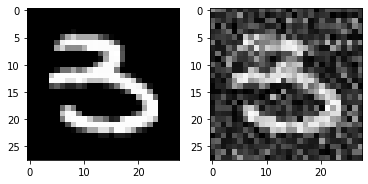

25  :  -0.8396859690580329 25
50  :  -0.7586528370351404 25
75  :  -0.7353178860656231 25
100  :  -0.7353178860656231 25
125  :  -0.6997131461674193 25
150  :  -0.6973122662348163 25
175  :  -0.6973122662348163 25
200  :  -0.6973122662348163 25
225  :  -0.6973122662348163 25
250  :  -0.6484117289949574 25
275  :  -0.6475301541604819 25
300  :  -0.6469392297593299 25
325  :  -0.640651136937763 25
350  :  -0.6413015615435826 25
375  :  -0.6092926222966732 25
400  :  -0.6088463948389025 25
425  :  -0.5806418750381181 25
450  :  -0.5806418750381181 25
475  :  -0.5806418750381181 25
500  :  -0.5806418750381181 25
525  :  -0.555747159372457 25
550  :  -0.5559900045208572 25
575  :  -0.5559900045208572 25
600  :  -0.5422529982671227 25
625  :  -0.5356919179983279 25
650  :  -0.5356919179983279 25
675  :  -0.5356919179983279 25
700  :  -0.5323667375148429 25
725  :  -0.5309521545800544 25
750  :  -0.5260249081821127 25
775  :  -0.5205691201184823 25
800  :  -0.5206168062416883 25
825  :  -0.51

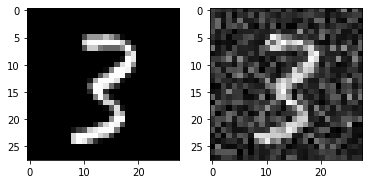

25  :  -0.8662261169330836 25
50  :  -0.8662261169330836 25
75  :  -0.8215324823532264 25
100  :  -0.8200343815775895 25
125  :  -0.7847756907888277 25
150  :  -0.7495405037263907 25
175  :  -0.7205443536945162 25
200  :  -0.7205443536945162 25
225  :  -0.7205443536945162 25
250  :  -0.6960144016513392 25
275  :  -0.6960144016513392 25
300  :  -0.6960144016513392 25
325  :  -0.6960144016513392 25
350  :  -0.6960144016513392 25
375  :  -0.6950731616460937 25
400  :  -0.6942981253617995 25
425  :  -0.6942981253617995 25
450  :  -0.6942981253617995 25
475  :  -0.6460223408419621 25
500  :  -0.6451390762900611 25
525  :  -0.6373990960703066 25
550  :  -0.6154709126447306 25
575  :  -0.6143332485449031 25
600  :  -0.6143332485449031 25
625  :  -0.6143332485449031 25
650  :  -0.6143332485449031 25
675  :  -0.5931662392503763 25
700  :  -0.5874729956107068 25
725  :  -0.5716819664231891 25
750  :  -0.5710426825812658 25
775  :  -0.5649674489695313 25
800  :  -0.5580375705972784 25
825  :  -0.

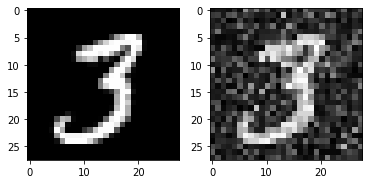

25  :  -0.8524093861585711 25
50  :  -0.8524093861585711 25
75  :  -0.7545241291796227 25
100  :  -0.7907832773387102 25
125  :  -0.7907832773387102 25
150  :  -0.7907832773387102 25
175  :  -0.7907832773387102 25
200  :  -0.7907832773387102 25
225  :  -0.7661830064918771 25
250  :  -0.7607402875561426 25
275  :  -0.7607402875561426 25
300  :  -0.7607402875561426 25
325  :  -0.7607402875561426 25
350  :  -0.7607402875561426 25
375  :  -0.730647581841027 25
400  :  -0.730647581841027 25
425  :  -0.72410730044889 25
450  :  -0.72410730044889 25
475  :  -0.721870003682775 25
500  :  -0.7234624425844336 25
525  :  -0.7109938567481386 25
550  :  -0.685378798774013 25
575  :  -0.685500918461553 25
600  :  -0.6723988726615315 25
625  :  -0.6710478359778889 25
650  :  -0.6701751785212056 25
675  :  -0.6493792721325953 25
700  :  -0.6488277473160569 25
725  :  -0.6472982532075824 25
750  :  -0.6472389040209678 25
775  :  -0.6472389040209678 25
800  :  -0.6472389040209678 25
825  :  -0.627016747

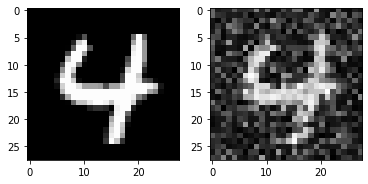

25  :  -0.78227106256312 25
50  :  -0.78227106256312 25
75  :  -0.78227106256312 25
100  :  -0.78227106256312 25
125  :  -0.78227106256312 25
150  :  -0.78227106256312 25
175  :  -0.78227106256312 25
200  :  -0.78227106256312 25
225  :  -0.771084983580441 25
250  :  -0.7147187254187306 25
275  :  -0.7147187254187306 25
300  :  -0.7099863863605576 25
325  :  -0.683346892227181 25
350  :  -0.6975474221588851 25
375  :  -0.6975474221588851 25
400  :  -0.6836679683830111 25
425  :  -0.6836679683830111 25
450  :  -0.6836679683830111 25
475  :  -0.6582702102289788 25
500  :  -0.6582702102289788 25
525  :  -0.6582702102289788 25
550  :  -0.6582702102289788 25
575  :  -0.6466444781341214 25
600  :  -0.6242677668519445 25
625  :  -0.6242677668519445 25
650  :  -0.6242677668519445 25
675  :  -0.6242677668519445 25
700  :  -0.621177611156098 25
725  :  -0.5988719103235305 25
750  :  -0.5974605440328138 25
775  :  -0.5981995414516765 25
800  :  -0.586413080229059 25
825  :  -0.5815896976995061 25


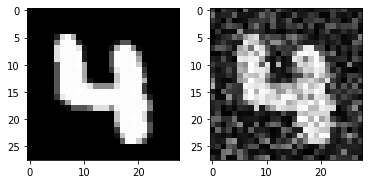

25  :  -1.6605250955405195 25
50  :  -1.6458918182620366 25
75  :  -1.6319623615729986 25
100  :  -1.5595096721453892 25
125  :  -1.5595096721453892 25
150  :  -1.5468632100464512 25
175  :  -1.5353806263087593 25
200  :  -1.5052468993095063 25
225  :  -1.50456558567957 25
250  :  -1.4009378811958038 25
275  :  -1.4009378811958038 25
300  :  -1.3835420482302148 25
325  :  -1.3833367083063934 25
350  :  -1.3802376644392105 25
375  :  -1.3801814943284039 25
400  :  -1.3594411289412893 25
425  :  -1.359425699017558 25
450  :  -1.356834473792889 25
475  :  -1.3457075821104165 25
500  :  -1.3404498379506455 25
525  :  -1.3340776947921746 25
550  :  -1.3340776947921746 25
575  :  -1.325066514567068 25
600  :  -1.325066514567068 25
625  :  -1.3189027055769351 25
650  :  -1.3155429050788061 25
675  :  -1.315542838072325 25
700  :  -1.315542838072325 25
725  :  -1.3151153894461545 25
750  :  -1.3131369437732765 25
775  :  -1.3122136536107294 25
800  :  -1.3101334284591584 25
825  :  -1.30903943

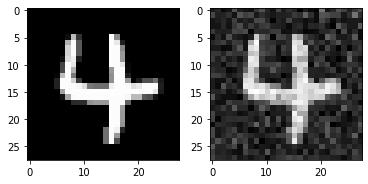

25  :  -0.8517746095429666 25
50  :  -0.8517746095429666 25
75  :  -0.7395851979517576 25
100  :  -0.6966544534423318 25
125  :  -0.6966544534423318 25
150  :  -0.6966544534423318 25
175  :  -0.6917723423654367 25
200  :  -0.6221029529024911 25
225  :  -0.601049793041361 25
250  :  -0.601049793041361 25
275  :  -0.601049793041361 25
300  :  -0.601049793041361 25
325  :  -0.601049793041361 25
350  :  -0.5680058157738532 25
375  :  -0.5680058157738532 25
400  :  -0.5680058157738532 25
425  :  -0.552662207637534 25
450  :  -0.5479903623600075 25
475  :  -0.5239171415861161 25
500  :  -0.5253830592983671 25
525  :  -0.5192582810446147 25
550  :  -0.5057619571331415 25
575  :  -0.5066747030045752 25
600  :  -0.5056397307186281 25
625  :  -0.5009069181168528 25
650  :  -0.5017852652907182 25
675  :  -0.5000008273882915 25
700  :  -0.500401412128934 25
725  :  -0.48657343719581536 25
750  :  -0.4865586101169327 25
775  :  -0.48843812164529077 25
800  :  -0.474341914512003 25
825  :  -0.474341

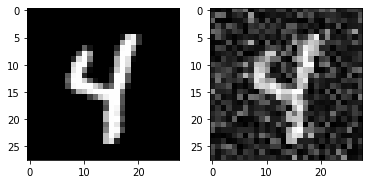

25  :  -0.9144485584730524 25
50  :  -0.7816477954742289 25
75  :  -0.6632421519749441 25
100  :  -0.6632421519749441 25
125  :  -0.6632421519749441 25
150  :  -0.6431879353408272 25
175  :  -0.640508230119917 25
200  :  -0.640508230119917 25
225  :  -0.640508230119917 25
250  :  -0.640508230119917 25
275  :  -0.640508230119917 25
300  :  -0.640508230119917 25
325  :  -0.6372671685861075 25
350  :  -0.6351975103492837 25
375  :  -0.6312788623713832 25
400  :  -0.6017224997487505 25
425  :  -0.6016415868308771 25
450  :  -0.6016415868308771 25
475  :  -0.573489737686435 25
500  :  -0.5729097261686997 25
525  :  -0.5677041282703685 25
550  :  -0.5678531390951964 25
575  :  -0.5674829609758645 25
600  :  -0.5658836572956876 25
625  :  -0.5658836572956876 25
650  :  -0.5588452767953562 25
675  :  -0.5503023800746942 25
700  :  -0.5503015748693785 25
725  :  -0.5499832722204476 25
750  :  -0.5423831780623205 25
775  :  -0.5423914587873535 25
800  :  -0.537447109711469 25
825  :  -0.53666609

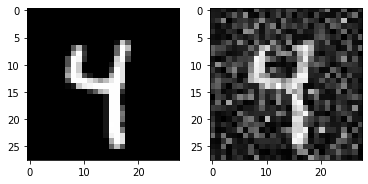

25  :  -0.708066081402319 25
50  :  -0.708066081402319 25
75  :  -0.6847474061481025 25
100  :  -0.6710086647894551 25
125  :  -0.608064979974924 25
150  :  -0.5987748354501037 25
175  :  -0.5987748354501037 25
200  :  -0.5987748354501037 25
225  :  -0.5987748354501037 25
250  :  -0.5987748354501037 25
275  :  -0.5737407716547027 25
300  :  -0.5737407716547027 25
325  :  -0.5737407716547027 25
350  :  -0.5613759605535222 25
375  :  -0.541189557685344 25
400  :  -0.528355746961052 25
425  :  -0.522598150062551 25
450  :  -0.5221702946054791 25
475  :  -0.5206389120820132 25
500  :  -0.4839987504948122 25
525  :  -0.4839987504948122 25
550  :  -0.47734481871843837 25
575  :  -0.4701654607912946 25
600  :  -0.4696538459056364 25
625  :  -0.4690408813240873 25
650  :  -0.4571307860904057 25
675  :  -0.4496831124268774 25
700  :  -0.44866768744932706 25
725  :  -0.4392907529175495 25
750  :  -0.436261544384845 25
775  :  -0.43423588852691886 25
800  :  -0.42899682872072464 25
825  :  -0.428

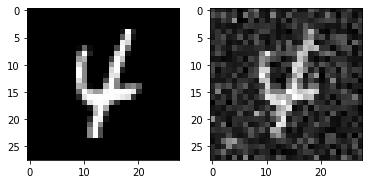

25  :  -0.8954491577150407 25
50  :  -0.8954491577150407 25
75  :  -0.7927894086013525 25
100  :  -0.7891205721598276 25
125  :  -0.682614535749863 25
150  :  -0.682614535749863 25
175  :  -0.682614535749863 25
200  :  -0.682614535749863 25
225  :  -0.6690984555949846 25
250  :  -0.6502649468039345 25
275  :  -0.6502649468039345 25
300  :  -0.6502649468039345 25
325  :  -0.6502649468039345 25
350  :  -0.6500455079996157 25
375  :  -0.6272159326183737 25
400  :  -0.6124798330586287 25
425  :  -0.6004805106728277 25
450  :  -0.5964800458544486 25
475  :  -0.596911361019018 25
500  :  -0.596911361019018 25
525  :  -0.5890292117661762 25
550  :  -0.5870900692249252 25
575  :  -0.5826250367555719 25
600  :  -0.5716062142131462 25
625  :  -0.5718205830166294 25
650  :  -0.5626066054953105 25
675  :  -0.5623564043799554 25
700  :  -0.5566332282575517 25
725  :  -0.5532883807984685 25
750  :  -0.5414069448082224 25
775  :  -0.5335761700124741 25
800  :  -0.5251059506609255 25
825  :  -0.519658

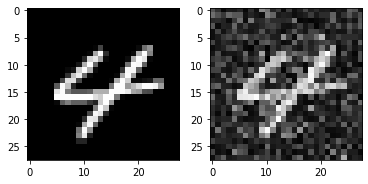

25  :  -0.7262007500823255 25
50  :  -0.7262007500823255 25
75  :  -0.7093737099130824 25
100  :  -0.7093737099130824 25
125  :  -0.7093737099130824 25
150  :  -0.7093737099130824 25
175  :  -0.7093737099130824 25
200  :  -0.7060196199574551 25
225  :  -0.6949134365637624 25
250  :  -0.6545077757111846 25
275  :  -0.649786988167427 25
300  :  -0.649786988167427 25
325  :  -0.649786988167427 25
350  :  -0.6080247485999193 25
375  :  -0.6035950180432439 25
400  :  -0.6032684855541004 25
425  :  -0.5861980878252593 25
450  :  -0.5703830119420779 25
475  :  -0.5572847509494177 25
500  :  -0.5498473940947446 25
525  :  -0.5498473940947446 25
550  :  -0.5478627372261604 25
575  :  -0.5478485824747472 25
600  :  -0.5469680037555764 25
625  :  -0.5443959402609675 25
650  :  -0.5357734702238297 25
675  :  -0.525730615388059 25
700  :  -0.525730615388059 25
725  :  -0.525730615388059 25
750  :  -0.525730615388059 25
775  :  -0.525730615388059 25
800  :  -0.5192008851279568 25
825  :  -0.51827614

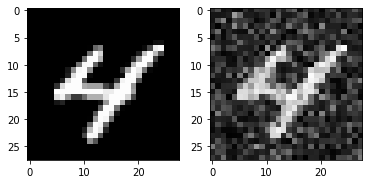

25  :  -0.7504084309178609 25
50  :  -0.7504084309178609 25
75  :  -0.6915876128360898 25
100  :  -0.6847623688146216 25
125  :  -0.5917533053244945 25
150  :  -0.5711486427625161 25
175  :  -0.5666492816206563 25
200  :  -0.5663031340041438 25
225  :  -0.5657761812764237 25
250  :  -0.5375597600580146 25
275  :  -0.5375597600580146 25
300  :  -0.5130880331832249 25
325  :  -0.5001022335903907 25
350  :  -0.48516311326568917 25
375  :  -0.48145155490343416 25
400  :  -0.46392018166817584 25
425  :  -0.45121756552615355 25
450  :  -0.4485992519727704 25
475  :  -0.43830111727773347 25
500  :  -0.4287143526252625 25
525  :  -0.4287143526252625 25
550  :  -0.4203248122473989 25
575  :  -0.4196468513917214 25
600  :  -0.4196468513917214 25
625  :  -0.4196468513917214 25
650  :  -0.41917038759985226 25
675  :  -0.41692819255027 25
700  :  -0.41679301145339387 25
725  :  -0.4143027679473835 25
750  :  -0.4142132516886098 25
775  :  -0.41395030333386185 25
800  :  -0.41294678906998283 25
825 

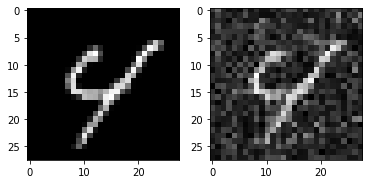

25  :  -1.0128793349728131 25
50  :  -1.0128793349728131 25
75  :  -0.8103226216126269 25
100  :  -0.8103226216126269 25
125  :  -0.8103226216126269 25
150  :  -0.8103226216126269 25
175  :  -0.8103226216126269 25
200  :  -0.7599208206031516 25
225  :  -0.7709462599811157 25
250  :  -0.7709462599811157 25
275  :  -0.7478669782796135 25
300  :  -0.7401655502371096 25
325  :  -0.7392876529150392 25
350  :  -0.7387969092314863 25
375  :  -0.7050194539618464 25
400  :  -0.7333017441114638 25
425  :  -0.7328846122697805 25
450  :  -0.7322624866203826 25
475  :  -0.7322624866203826 25
500  :  -0.728668271567124 25
525  :  -0.7174018340747488 25
550  :  -0.7146851095230413 25
575  :  -0.6849206870065725 25
600  :  -0.6646331297880208 25
625  :  -0.6650769239972782 25
650  :  -0.6650769239972782 25
675  :  -0.6601090743933635 25
700  :  -0.6381755951373183 25
725  :  -0.6381755951373183 25
750  :  -0.6358240647777693 25
775  :  -0.6358854693377296 25
800  :  -0.6252267642434197 25
825  :  -0.6

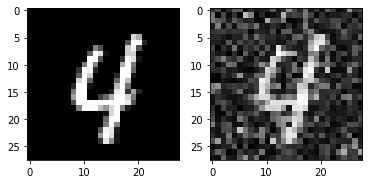

25  :  -0.8701795425705996 25
50  :  -0.8581679037241212 25
75  :  -0.8271230265697851 25
100  :  -0.6263561833653983 25
125  :  -0.6263561833653983 25
150  :  -0.6263561833653983 25
175  :  -0.6263561833653983 25
200  :  -0.6263561833653983 25
225  :  -0.582493615066757 25
250  :  -0.582493615066757 25
275  :  -0.582493615066757 25
300  :  -0.582493615066757 25
325  :  -0.582493615066757 25
350  :  -0.582493615066757 25
375  :  -0.582493615066757 25
400  :  -0.5691699913764023 25
425  :  -0.5559187953282057 25
450  :  -0.5559187953282057 25
475  :  -0.5160689366252547 25
500  :  -0.5160689366252547 25
525  :  -0.5160689366252547 25
550  :  -0.5160689366252547 25
575  :  -0.5160689366252547 25
600  :  -0.5160689366252547 25
625  :  -0.5160689366252547 25
650  :  -0.5160689366252547 25
675  :  -0.5160689366252547 25
700  :  -0.5049846652168337 25
725  :  -0.49824287295188296 25
750  :  -0.4942859679676098 25
775  :  -0.4829880211038534 25
800  :  -0.4614035884283527 25
825  :  -0.461403

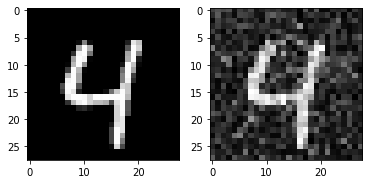

25  :  -0.7424762937946972 25
50  :  -0.7018592698299018 25
75  :  -0.7018592698299018 25
100  :  -0.7018592698299018 25
125  :  -0.7018592698299018 25
150  :  -0.6502448634489504 25
175  :  -0.6502448634489504 25
200  :  -0.6502448634489504 25
225  :  -0.6502448634489504 25
250  :  -0.6502448634489504 25
275  :  -0.6230686723511507 25
300  :  -0.6230686723511507 25
325  :  -0.6230686723511507 25
350  :  -0.6230686723511507 25
375  :  -0.6230686723511507 25
400  :  -0.6117258005582058 25
425  :  -0.5969833225898995 25
450  :  -0.5969833225898995 25
475  :  -0.5969833225898995 25
500  :  -0.5969833225898995 25
525  :  -0.5969833225898995 25
550  :  -0.5887486761743581 25
575  :  -0.5819947553583416 25
600  :  -0.5773511640446669 25
625  :  -0.575144362763637 25
650  :  -0.5691495581440684 25
675  :  -0.5679015546182544 25
700  :  -0.5679126786733204 25
725  :  -0.5653260516580589 25
750  :  -0.5630076834701025 25
775  :  -0.5553980551444309 25
800  :  -0.5517783765074245 25
825  :  -0.5

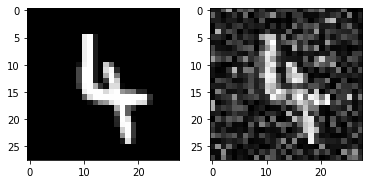

25  :  -0.6744854048835469 25
50  :  -0.6744854048835469 25
75  :  -0.6744854048835469 25
100  :  -0.5850282565185407 25
125  :  -0.5850282565185407 25
150  :  -0.5850282565185407 25
175  :  -0.5681431133220904 25
200  :  -0.5654928016089702 25
225  :  -0.5654928016089702 25
250  :  -0.5654928016089702 25
275  :  -0.5654928016089702 25
300  :  -0.5654928016089702 25
325  :  -0.5610198814348077 25
350  :  -0.5329669368136019 25
375  :  -0.532279204341302 25
400  :  -0.5318827288099544 25
425  :  -0.5277103402114585 25
450  :  -0.5295081159242425 25
475  :  -0.5170495357021523 25
500  :  -0.5054800802015299 25
525  :  -0.5079790131681698 25
550  :  -0.5079790131681698 25
575  :  -0.5079790131681698 25
600  :  -0.5079790131681698 25
625  :  -0.49689032212726414 25
650  :  -0.4839873919992289 25
675  :  -0.48185766727503043 25
700  :  -0.4825412393003158 25
725  :  -0.4825412393003158 25
750  :  -0.46101200670089826 25
775  :  -0.46101200670089826 25
800  :  -0.46101200670089826 25
825  : 

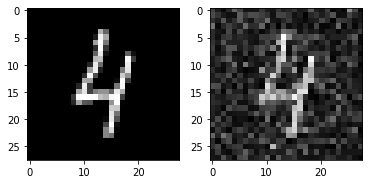

25  :  -0.6917184030011874 25
50  :  -0.6917184030011874 25
75  :  -0.6469345188804929 25
100  :  -0.6469345188804929 25
125  :  -0.6469345188804929 25
150  :  -0.6469345188804929 25
175  :  -0.638840545829239 25
200  :  -0.626617985873746 25
225  :  -0.5849038167839615 25
250  :  -0.5813838843978825 25
275  :  -0.5724299195330964 25
300  :  -0.574539187582155 25
325  :  -0.5484798558168196 25
350  :  -0.5188941853117115 25
375  :  -0.5191846316269859 25
400  :  -0.5190584489320029 25
425  :  -0.5190397715766455 25
450  :  -0.5190397715766455 25
475  :  -0.5190397715766455 25
500  :  -0.5065027388364735 25
525  :  -0.4903188591644727 25
550  :  -0.4773351402398782 25
575  :  -0.4784569488228251 25
600  :  -0.4766351701718241 25
625  :  -0.4768824625444472 25
650  :  -0.4614983660774622 25
675  :  -0.45069039983812464 25
700  :  -0.4508130692186826 25
725  :  -0.4508130692186826 25
750  :  -0.4508130692186826 25
775  :  -0.44176643476098876 25
800  :  -0.4358048512540663 25
825  :  -0.4

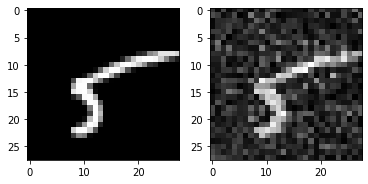

25  :  -0.9441979898523507 25
50  :  -0.9441979898523507 25
75  :  -0.8514887005972507 25
100  :  -0.8361298575677152 25
125  :  -0.8361298575677152 25
150  :  -0.8361298575677152 25
175  :  -0.8361298575677152 25
200  :  -0.8361298575677152 25
225  :  -0.8361298575677152 25
250  :  -0.8361298575677152 25
275  :  -0.7835650555296712 25
300  :  -0.7805962612146697 25
325  :  -0.7805962612146697 25
350  :  -0.7805962612146697 25
375  :  -0.7805962612146697 25
400  :  -0.7805962612146697 25
425  :  -0.7805962612146697 25
450  :  -0.7607980054854206 25
475  :  -0.7589208077543177 25
500  :  -0.7570150209383277 25
525  :  -0.7361989936441014 25
550  :  -0.7312703542916428 25
575  :  -0.7311460964936425 25
600  :  -0.728977676846742 25
625  :  -0.7150107898065532 25
650  :  -0.7055122207618867 25
675  :  -0.7055122207618867 25
700  :  -0.7055122207618867 25
725  :  -0.7055122207618867 25
750  :  -0.7055122207618867 25
775  :  -0.6482129248621769 25
800  :  -0.648297287222543 25
825  :  -0.64

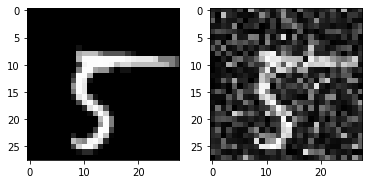

25  :  -0.6781848191063278 25
50  :  -0.6781848191063278 25
75  :  -0.6781848191063278 25
100  :  -0.6575282929489101 25
125  :  -0.6575282929489101 25
150  :  -0.6575282929489101 25
175  :  -0.6575282929489101 25
200  :  -0.6575282929489101 25
225  :  -0.5984019755377328 25
250  :  -0.5913714423546215 25
275  :  -0.5913714423546215 25
300  :  -0.5756881952732362 25
325  :  -0.5728311734589933 25
350  :  -0.5564343057033971 25
375  :  -0.5404237772144813 25
400  :  -0.5289042638088461 25
425  :  -0.5354171434451596 25
450  :  -0.5330948454131987 25
475  :  -0.5296707348646204 25
500  :  -0.5218371345595902 25
525  :  -0.4954837389155713 25
550  :  -0.4825130904841528 25
575  :  -0.4630167390340503 25
600  :  -0.4639606206371254 25
625  :  -0.4639606206371254 25
650  :  -0.45679995305165433 25
675  :  -0.4508226650617332 25
700  :  -0.4415817810377939 25
725  :  -0.4328083005481812 25
750  :  -0.4328083005481812 25
775  :  -0.4328083005481812 25
800  :  -0.42811242712060715 25
825  :  -

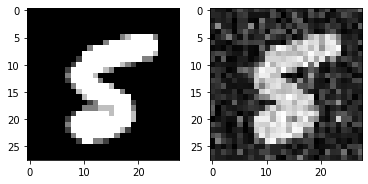

25  :  -1.1986789185792497 25
50  :  -1.1986789185792497 25
75  :  -0.9470527637767798 25
100  :  -0.9470527637767798 25
125  :  -0.9470527637767798 25
150  :  -0.9081405712010093 25
175  :  -0.8845929495955671 25
200  :  -0.8182907763832092 25
225  :  -0.7913742391457557 25
250  :  -0.7913742391457557 25
275  :  -0.7913742391457557 25
300  :  -0.7913742391457557 25
325  :  -0.7913742391457557 25
350  :  -0.7913742391457557 25
375  :  -0.7913742391457557 25
400  :  -0.7913742391457557 25
425  :  -0.7910812400508629 25
450  :  -0.7918436828046245 25
475  :  -0.757359069069649 25
500  :  -0.743557138730746 25
525  :  -0.7367121589552645 25
550  :  -0.7372463808119782 25
575  :  -0.7342323352025915 25
600  :  -0.7153224896713537 25
625  :  -0.714297246072406 25
650  :  -0.7043051486444916 25
675  :  -0.6977323323430826 25
700  :  -0.6888980363021575 25
725  :  -0.6903616097164573 25
750  :  -0.6846356014282973 25
775  :  -0.6842788029883184 25
800  :  -0.6814476540010352 25
825  :  -0.679

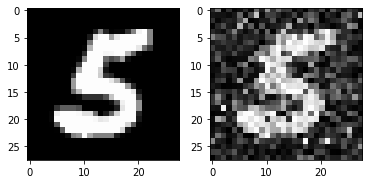

25  :  -0.7530185694864397 25
50  :  -0.7530185694864397 25
75  :  -0.7203785030537606 25
100  :  -0.7203785030537606 25
125  :  -0.7203785030537606 25
150  :  -0.7203785030537606 25
175  :  -0.6843429141486805 25
200  :  -0.6812720988781089 25
225  :  -0.6711604149084376 25
250  :  -0.645091840476963 25
275  :  -0.6052510848859045 25
300  :  -0.6007517716600181 25
325  :  -0.5719961521892616 25
350  :  -0.5663032230734475 25
375  :  -0.5667248786591386 25
400  :  -0.5400435476420338 25
425  :  -0.5306697168379555 25
450  :  -0.5307876434007015 25
475  :  -0.5307876434007015 25
500  :  -0.520835526413145 25
525  :  -0.5101759067684948 25
550  :  -0.5054857124619014 25
575  :  -0.49915538853358565 25
600  :  -0.49915538853358565 25
625  :  -0.4952294713280897 25
650  :  -0.48500289332910096 25
675  :  -0.48486212421615715 25
700  :  -0.4807844057539923 25
725  :  -0.47655026505031406 25
750  :  -0.4748469866522286 25
775  :  -0.47133619449036657 25
800  :  -0.4645870978325418 25
825  : 

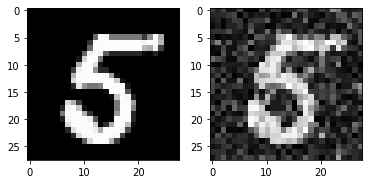

25  :  -0.7690466153082673 25
50  :  -0.7677265737919039 25
75  :  -0.732676324440515 25
100  :  -0.6758042586333723 25
125  :  -0.6478763269505234 25
150  :  -0.617550584557871 25
175  :  -0.6126818059569046 25
200  :  -0.6126818059569046 25
225  :  -0.6126818059569046 25
250  :  -0.6126818059569046 25
275  :  -0.6126818059569046 25
300  :  -0.5781352147469432 25
325  :  -0.5781352147469432 25
350  :  -0.5233162770312154 25
375  :  -0.5233162770312154 25
400  :  -0.5187377356848963 25
425  :  -0.44531961128542963 25
450  :  -0.44531961128542963 25
475  :  -0.44531961128542963 25
500  :  -0.4444394954201769 25
525  :  -0.43632294622325496 25
550  :  -0.4207557332895737 25
575  :  -0.3993315721163979 25
600  :  -0.3993313671560562 25
625  :  -0.3993313671560562 25
650  :  -0.3993313671560562 25
675  :  -0.3905102098962884 25
700  :  -0.3905102098962884 25
725  :  -0.3905102098962884 25
750  :  -0.3905102098962884 25
775  :  -0.3905102098962884 25
800  :  -0.3795396387778772 25
825  :  -

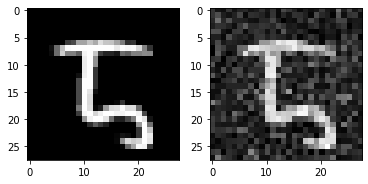

25  :  -0.7029534866952687 25
50  :  -0.6179242084378982 25
75  :  -0.6200032502671382 25
100  :  -0.5826079600589851 25
125  :  -0.563707679328856 25
150  :  -0.5261802148787058 25
175  :  -0.5265326011724445 25
200  :  -0.5265326011724445 25
225  :  -0.5114492306003202 25
250  :  -0.5119541242465564 25
275  :  -0.4807798585297406 25
300  :  -0.48067436890360193 25
325  :  -0.4587558599076489 25
350  :  -0.4566315748168298 25
375  :  -0.42787561504199656 25
400  :  -0.4280349404885484 25
425  :  -0.4280349404885484 25
450  :  -0.41366109460698663 25
475  :  -0.41148597306272694 25
500  :  -0.40582996135073346 25
525  :  -0.40578632436002726 25
550  :  -0.3978561206695119 25
575  :  -0.3978710362138902 25
600  :  -0.3957715935867767 25
625  :  -0.3947762630290975 25
650  :  -0.3909933955015573 25
675  :  -0.38975886722006026 25
700  :  -0.3871807910974677 25
725  :  -0.3809361331276683 25
750  :  -0.3809361331276683 25
775  :  -0.37532169576545193 25
800  :  -0.37532169576545193 25
825

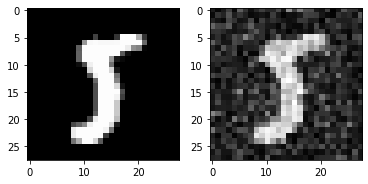

25  :  -0.7034258952197274 25
50  :  -0.6441223339948277 25
75  :  -0.5964148995313374 25
100  :  -0.588203274088013 25
125  :  -0.588203274088013 25
150  :  -0.588203274088013 25
175  :  -0.5354724949995648 25
200  :  -0.5356024033967559 25
225  :  -0.5356024033967559 25
250  :  -0.5356024033967559 25
275  :  -0.5173128788304278 25
300  :  -0.5131772130645853 25
325  :  -0.5052493653398754 25
350  :  -0.5027236654244387 25
375  :  -0.47779905080271934 25
400  :  -0.47329727618660855 25
425  :  -0.4648426055149891 25
450  :  -0.45633628736766385 25
475  :  -0.44556544852952873 25
500  :  -0.4403161320770774 25
525  :  -0.4334215367615005 25
550  :  -0.42720288428435405 25
575  :  -0.42720288428435405 25
600  :  -0.4246884585824441 25
625  :  -0.4173365270013054 25
650  :  -0.41159710746817724 25
675  :  -0.41159710746817724 25
700  :  -0.41057979070507855 25
725  :  -0.40964626578515795 25
750  :  -0.40707828632421106 25
775  :  -0.4064725012816892 25
800  :  -0.4061507998005829 25
825

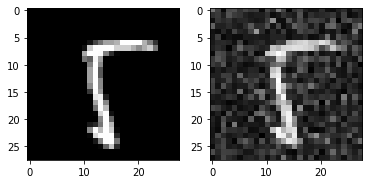

25  :  -1.0684506656975312 25
50  :  -0.9100049233860672 25
75  :  -0.8310474159856356 25
100  :  -0.8218283931873156 25
125  :  -0.8218283931873156 25
150  :  -0.8218283931873156 25
175  :  -0.8218283931873156 25
200  :  -0.8218283931873156 25
225  :  -0.7893107170855993 25
250  :  -0.7866551073623451 25
275  :  -0.7530956959890229 25
300  :  -0.7682649542708431 25
325  :  -0.6638019502373798 25
350  :  -0.6788572531697918 25
375  :  -0.6788572531697918 25
400  :  -0.6788572531697918 25
425  :  -0.6728873635900698 25
450  :  -0.6601194692574066 25
475  :  -0.6443232219063646 25
500  :  -0.6182213247611734 25
525  :  -0.6019647858130133 25
550  :  -0.6019985200438396 25
575  :  -0.6019985200438396 25
600  :  -0.5936111099979697 25
625  :  -0.5936111099979697 25
650  :  -0.5923924515329171 25
675  :  -0.5911809113724003 25
700  :  -0.5834884075921483 25
725  :  -0.5835153674020868 25
750  :  -0.5752437183968642 25
775  :  -0.5752437183968642 25
800  :  -0.5752437183968642 25
825  :  -0.

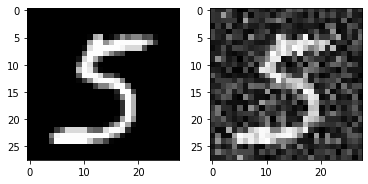

25  :  -0.7360921019431097 25
50  :  -0.7013189258750139 25
75  :  -0.6128328490063357 25
100  :  -0.6128328490063357 25
125  :  -0.6128328490063357 25
150  :  -0.6128328490063357 25
175  :  -0.6128328490063357 25
200  :  -0.6128328490063357 25
225  :  -0.6128328490063357 25
250  :  -0.6128328490063357 25
275  :  -0.6128328490063357 25
300  :  -0.5995294598565108 25
325  :  -0.59503486384336 25
350  :  -0.55723228790532 25
375  :  -0.5550754947681507 25
400  :  -0.5546921897602954 25
425  :  -0.5506990972782566 25
450  :  -0.5375927990726417 25
475  :  -0.4732565186927902 25
500  :  -0.4726025796526053 25
525  :  -0.4640590256914455 25
550  :  -0.44950414711305897 25
575  :  -0.4472644845072068 25
600  :  -0.43628065910611435 25
625  :  -0.43628065910611435 25
650  :  -0.4327434300793248 25
675  :  -0.43148070753481815 25
700  :  -0.42648202403647273 25
725  :  -0.4158711313236485 25
750  :  -0.4115957450465533 25
775  :  -0.4115957450465533 25
800  :  -0.40741266006086463 25
825  :  -

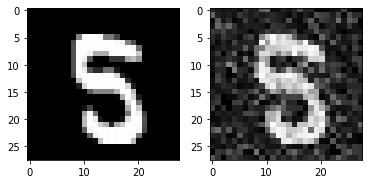

25  :  -0.7799759399292874 25
50  :  -0.7799759399292874 25
75  :  -0.775836451671462 25
100  :  -0.7525339309973611 25
125  :  -0.7277581106834135 25
150  :  -0.7125313747261057 25
175  :  -0.7125313747261057 25
200  :  -0.702252904810305 25
225  :  -0.7008189005072067 25
250  :  -0.6425254277191497 25
275  :  -0.6315396148037229 25
300  :  -0.6033827910579885 25
325  :  -0.6033827910579885 25
350  :  -0.5367212358142204 25
375  :  -0.5367212358142204 25
400  :  -0.5367212358142204 25
425  :  -0.5367212358142204 25
450  :  -0.5367212358142204 25
475  :  -0.5343338777085178 25
500  :  -0.5229155089201196 25
525  :  -0.5203676513775248 25
550  :  -0.5203676513775248 25
575  :  -0.5179089328031752 25
600  :  -0.5179089328031752 25
625  :  -0.5179089328031752 25
650  :  -0.5148708475470365 25
675  :  -0.5108249862928049 25
700  :  -0.5108249862928049 25
725  :  -0.5095489080278337 25
750  :  -0.5071946205851238 25
775  :  -0.5070385691562873 25
800  :  -0.506081301728386 25
825  :  -0.503

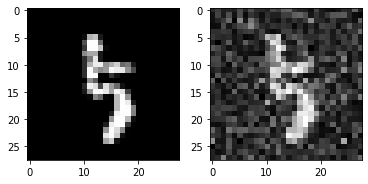

25  :  -0.7310461109823476 25
50  :  -0.7310461109823476 25
75  :  -0.65110306326101 25
100  :  -0.6404482943126251 25
125  :  -0.6404482943126251 25
150  :  -0.6404482943126251 25
175  :  -0.6394033935175976 25
200  :  -0.6385443408708114 25
225  :  -0.6162798326977095 25
250  :  -0.6121245322942361 25
275  :  -0.6094374136050429 25
300  :  -0.6035980675525645 25
325  :  -0.5680558574113621 25
350  :  -0.5620670376124759 25
375  :  -0.5238428546871943 25
400  :  -0.5119165427668132 25
425  :  -0.48658177516862633 25
450  :  -0.47216799039902846 25
475  :  -0.4708326522579488 25
500  :  -0.4666991382390885 25
525  :  -0.4652554598253297 25
550  :  -0.45283868936091043 25
575  :  -0.4528251505832629 25
600  :  -0.43894872747680724 25
625  :  -0.43894872747680724 25
650  :  -0.43894872747680724 25
675  :  -0.43075275081120123 25
700  :  -0.424644993238525 25
725  :  -0.424644993238525 25
750  :  -0.4227328388179945 25
775  :  -0.4175582839607833 25
800  :  -0.4175582839607833 25
825  :  

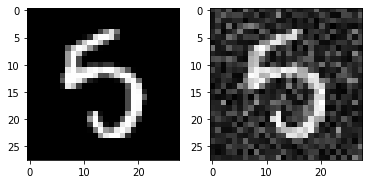

25  :  -0.7707754707281977 25
50  :  -0.741182683187738 25
75  :  -0.7470310084328433 25
100  :  -0.7470310084328433 25
125  :  -0.6902263135521474 25
150  :  -0.6536729754264572 25
175  :  -0.6548850580915202 25
200  :  -0.605573587797614 25
225  :  -0.5373485356060217 25
250  :  -0.5360436355154994 25
275  :  -0.5360436355154994 25
300  :  -0.5360436355154994 25
325  :  -0.4773623455286621 25
350  :  -0.47542052175685523 25
375  :  -0.47542052175685523 25
400  :  -0.4603354202003922 25
425  :  -0.4576602840444407 25
450  :  -0.4566421306960743 25
475  :  -0.4565215428972047 25
500  :  -0.4498187662230013 25
525  :  -0.4304917184424396 25
550  :  -0.43052114116538254 25
575  :  -0.42618583755398687 25
600  :  -0.4161612790312126 25
625  :  -0.4162832507568758 25
650  :  -0.4162832507568758 25
675  :  -0.4162832507568758 25
700  :  -0.4145590514677078 25
725  :  -0.4113367826250799 25
750  :  -0.4113367826250799 25
775  :  -0.40903679798755055 25
800  :  -0.4090374140117561 25
825  :  

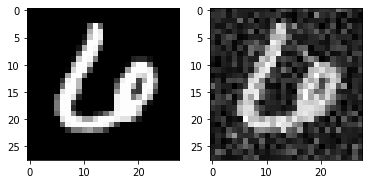

25  :  -1.4833052356190222 25
50  :  -1.0498279026912956 25
75  :  -0.928165843052154 25
100  :  -0.928165843052154 25
125  :  -0.8853210274700192 25
150  :  -0.8989002552749632 25
175  :  -0.8902279624848379 25
200  :  -0.8739624523480589 25
225  :  -0.8203251103482727 25
250  :  -0.8195638166901988 25
275  :  -0.7298367421913126 25
300  :  -0.7274274014999571 25
325  :  -0.7274274014999571 25
350  :  -0.7274274014999571 25
375  :  -0.7123557717774744 25
400  :  -0.6629472999367985 25
425  :  -0.6722574190392534 25
450  :  -0.6722574190392534 25
475  :  -0.668792743087967 25
500  :  -0.6669027596987565 25
525  :  -0.6654080498826986 25
550  :  -0.6654080498826986 25
575  :  -0.6654080498826986 25
600  :  -0.6545359268217783 25
625  :  -0.6499932155833716 25
650  :  -0.638819747322374 25
675  :  -0.635300382322779 25
700  :  -0.6323812136147835 25
725  :  -0.6323812136147835 25
750  :  -0.6257448885075094 25
775  :  -0.6257448885075094 25
800  :  -0.6204438081811514 25
825  :  -0.62044

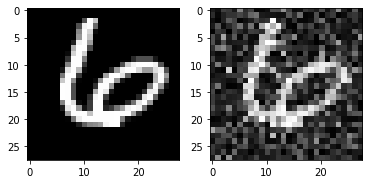

25  :  -0.9170560957700578 25
50  :  -0.9170560957700578 25
75  :  -0.9519839647541553 25
100  :  -0.9163796638836774 25
125  :  -0.8911457107863789 25
150  :  -0.8911457107863789 25
175  :  -0.8911457107863789 25
200  :  -0.8911457107863789 25
225  :  -0.7976199709766905 25
250  :  -0.7976199709766905 25
275  :  -0.7487324130094863 25
300  :  -0.7437495322896917 25
325  :  -0.7437495322896917 25
350  :  -0.7437495322896917 25
375  :  -0.7437495322896917 25
400  :  -0.7437495322896917 25
425  :  -0.7437495322896917 25
450  :  -0.7437495322896917 25
475  :  -0.7437495322896917 25
500  :  -0.7437495322896917 25
525  :  -0.7437495322896917 25
550  :  -0.7437495322896917 25
575  :  -0.7369440765697597 25
600  :  -0.7369440765697597 25
625  :  -0.7369440765697597 25
650  :  -0.7369440765697597 25
675  :  -0.7369440765697597 25
700  :  -0.7210968771659438 25
725  :  -0.7234718229767889 25
750  :  -0.7234718229767889 25
775  :  -0.7078694949174085 25
800  :  -0.7078694949174085 25
825  :  -0.

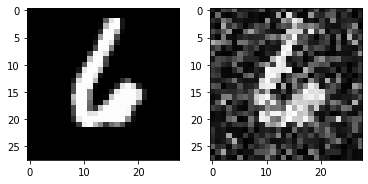

25  :  -0.7625858043236047 25
50  :  -0.7625858043236047 25
75  :  -0.7478531729303979 25
100  :  -0.7478531729303979 25
125  :  -0.7450978711890572 25
150  :  -0.6348072554448083 25
175  :  -0.6348072554448083 25
200  :  -0.616206007783527 25
225  :  -0.611385270074537 25
250  :  -0.6016705271852352 25
275  :  -0.5958006362411081 25
300  :  -0.5937867056997264 25
325  :  -0.5437937654876204 25
350  :  -0.5429403925703442 25
375  :  -0.5429403925703442 25
400  :  -0.5429403925703442 25
425  :  -0.5361466823022791 25
450  :  -0.5049422594479943 25
475  :  -0.4916359529019526 25
500  :  -0.4904367863411693 25
525  :  -0.48487567856343883 25
550  :  -0.4848051329598456 25
575  :  -0.4806350527602268 25
600  :  -0.4792489575204796 25
625  :  -0.4755680297227325 25
650  :  -0.4715306673310493 25
675  :  -0.4713114971520932 25
700  :  -0.4648071085492561 25
725  :  -0.4648071085492561 25
750  :  -0.4648071085492561 25
775  :  -0.4648071085492561 25
800  :  -0.46219284442245856 25
825  :  -0.

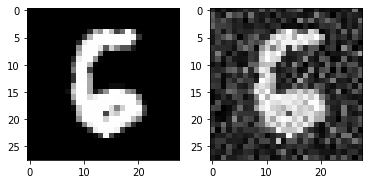

25  :  -1.0606127288809255 25
50  :  -0.9315515866248789 25
75  :  -0.9059593187346595 25
100  :  -0.8684866331503087 25
125  :  -0.8594770425318548 25
150  :  -0.8594770425318548 25
175  :  -0.8594770425318548 25
200  :  -0.8422711439320922 25
225  :  -0.8264420448893284 25
250  :  -0.8239685690917806 25
275  :  -0.8188654404880167 25
300  :  -0.7905126374933316 25
325  :  -0.7473784307483458 25
350  :  -0.7473784307483458 25
375  :  -0.7355227497115855 25
400  :  -0.7355227497115855 25
425  :  -0.7355227497115855 25
450  :  -0.7311859885040894 25
475  :  -0.7312607478809299 25
500  :  -0.7232709983351997 25
525  :  -0.7094733895191443 25
550  :  -0.7086117048222167 25
575  :  -0.7005952510977456 25
600  :  -0.7005952510977456 25
625  :  -0.7005952510977456 25
650  :  -0.7005952510977456 25
675  :  -0.6917253576929543 25
700  :  -0.686004027422376 25
725  :  -0.686004027422376 25
750  :  -0.686004027422376 25
775  :  -0.686004027422376 25
800  :  -0.684708357200476 25
825  :  -0.68393

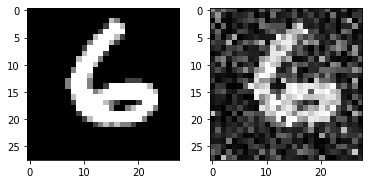

25  :  -0.809771224670909 25
50  :  -0.781731802728233 25
75  :  -0.7464112962520644 25
100  :  -0.7464112962520644 25
125  :  -0.7464112962520644 25
150  :  -0.7464112962520644 25
175  :  -0.7464112962520644 25
200  :  -0.7464112962520644 25
225  :  -0.7464112962520644 25
250  :  -0.7464112962520644 25
275  :  -0.704550939375761 25
300  :  -0.6574424420774034 25
325  :  -0.6574424420774034 25
350  :  -0.6574424420774034 25
375  :  -0.6574424420774034 25
400  :  -0.6574424420774034 25
425  :  -0.6402392538036785 25
450  :  -0.6177137097271099 25
475  :  -0.6156489676032908 25
500  :  -0.6156489676032908 25
525  :  -0.5924170343965023 25
550  :  -0.5924170343965023 25
575  :  -0.5924170343965023 25
600  :  -0.5924170343965023 25
625  :  -0.5914912463053188 25
650  :  -0.5762769309395901 25
675  :  -0.5642351302774264 25
700  :  -0.5642351302774264 25
725  :  -0.5642351302774264 25
750  :  -0.5642351302774264 25
775  :  -0.5574860523103526 25
800  :  -0.5559841419614122 25
825  :  -0.543

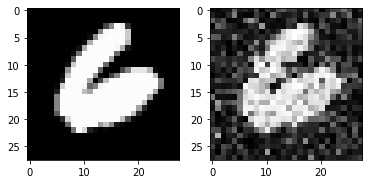

25  :  -0.7762054637161786 25
50  :  -0.7531796022206871 25
75  :  -0.6930108891602225 25
100  :  -0.690589331039478 25
125  :  -0.6669694127819683 25
150  :  -0.6399079017119942 25
175  :  -0.5382822932972533 25
200  :  -0.5382822932972533 25
225  :  -0.5382822932972533 25
250  :  -0.5312645735952124 25
275  :  -0.47364452018412784 25
300  :  -0.47364452018412784 25
325  :  -0.4685586725009089 25
350  :  -0.428188322685909 25
375  :  -0.4219252896237794 25
400  :  -0.4226884411835746 25
425  :  -0.41737502988507424 25
450  :  -0.4036479071648239 25
475  :  -0.4036882726643317 25
500  :  -0.4036882726643317 25
525  :  -0.4036882726643317 25
550  :  -0.39216849499849626 25
575  :  -0.39216849499849626 25
600  :  -0.39216849499849626 25
625  :  -0.39216849499849626 25
650  :  -0.39216849499849626 25
675  :  -0.3834872001895402 25
700  :  -0.3834872001895402 25
725  :  -0.3834872001895402 25
750  :  -0.37118370918341137 25
775  :  -0.369677103528404 25
800  :  -0.36963862181130813 25
825 

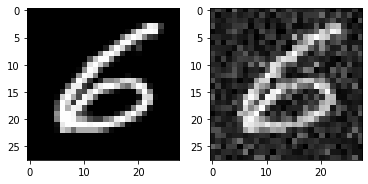

25  :  -0.706593238844506 25
50  :  -0.7018346031652614 25
75  :  -0.706593238844506 25
100  :  -0.6621945135104081 25
125  :  -0.6621945135104081 25
150  :  -0.6621945135104081 25
175  :  -0.6621945135104081 25
200  :  -0.6443121761192587 25
225  :  -0.6115113813224546 25
250  :  -0.5540496564711264 25
275  :  -0.5142734799074148 25
300  :  -0.5142734799074148 25
325  :  -0.5142734799074148 25
350  :  -0.5142734799074148 25
375  :  -0.5142734799074148 25
400  :  -0.5142734799074148 25
425  :  -0.48325114244078315 25
450  :  -0.4835712099882552 25
475  :  -0.4835712099882552 25
500  :  -0.4776313570144144 25
525  :  -0.4734419775062445 25
550  :  -0.46037299201308235 25
575  :  -0.4470149724899686 25
600  :  -0.44429509187869676 25
625  :  -0.4442072585138337 25
650  :  -0.4339051704209108 25
675  :  -0.43048610897187367 25
700  :  -0.42616215631182885 25
725  :  -0.4233100623517443 25
750  :  -0.4233368201890314 25
775  :  -0.4099712345179227 25
800  :  -0.4099621280171377 25
825  :  

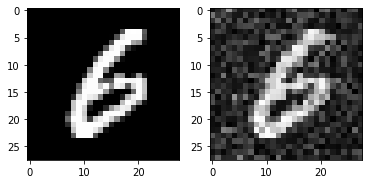

25  :  -0.9825851966441643 25
50  :  -0.9825851966441643 25
75  :  -0.8446532152755606 25
100  :  -0.8508439249785795 25
125  :  -0.8508439249785795 25
150  :  -0.7825641187263797 25
175  :  -0.7825641187263797 25
200  :  -0.7825641187263797 25
225  :  -0.7825641187263797 25
250  :  -0.7586285413597351 25
275  :  -0.7586022336074889 25
300  :  -0.7324736349883687 25
325  :  -0.72106414312756 25
350  :  -0.7183498980114955 25
375  :  -0.712212078404898 25
400  :  -0.6958656892148727 25
425  :  -0.6958656892148727 25
450  :  -0.6958656892148727 25
475  :  -0.6900208900108895 25
500  :  -0.6824474917085366 25
525  :  -0.6629046023971326 25
550  :  -0.6386640509904682 25
575  :  -0.6382457416026912 25
600  :  -0.6382457416026912 25
625  :  -0.6382457416026912 25
650  :  -0.6246419866802329 25
675  :  -0.6246419866802329 25
700  :  -0.6099426822291494 25
725  :  -0.6099426822291494 25
750  :  -0.6099426822291494 25
775  :  -0.6011034702434792 25
800  :  -0.5988846830484984 25
825  :  -0.598

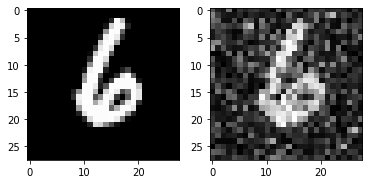

25  :  -0.7684065871719872 25
50  :  -0.7684065871719872 25
75  :  -0.7542235888326079 25
100  :  -0.6620908582809546 25
125  :  -0.6579679389261008 25
150  :  -0.6579679389261008 25
175  :  -0.6579679389261008 25
200  :  -0.6304330881344784 25
225  :  -0.6346919030009708 25
250  :  -0.5977349073069307 25
275  :  -0.5977349073069307 25
300  :  -0.5977349073069307 25
325  :  -0.5767590471761637 25
350  :  -0.5787355591278365 25
375  :  -0.5787355591278365 25
400  :  -0.5787355591278365 25
425  :  -0.5782035972188915 25
450  :  -0.5162088839284245 25
475  :  -0.5162102472848467 25
500  :  -0.5162102472848467 25
525  :  -0.5162102472848467 25
550  :  -0.5051917442621846 25
575  :  -0.5035787952352553 25
600  :  -0.5035190603528678 25
625  :  -0.4977988495937129 25
650  :  -0.4933351719171728 25
675  :  -0.4933351719171728 25
700  :  -0.486510306376031 25
725  :  -0.486510306376031 25
750  :  -0.486510306376031 25
775  :  -0.4810062623536633 25
800  :  -0.48112774705465744 25
825  :  -0.48

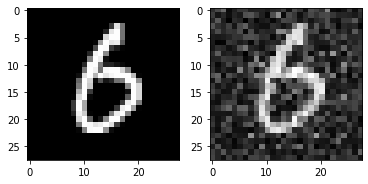

25  :  -0.755919870622076 25
50  :  -0.755919870622076 25
75  :  -0.755919870622076 25
100  :  -0.755919870622076 25
125  :  -0.755919870622076 25
150  :  -0.7464531852001157 25
175  :  -0.7464531852001157 25
200  :  -0.7038256114444075 25
225  :  -0.7038256114444075 25
250  :  -0.6967062399579207 25
275  :  -0.7062510816315772 25
300  :  -0.6616506422897341 25
325  :  -0.6517891798103725 25
350  :  -0.6544736812515202 25
375  :  -0.6544736812515202 25
400  :  -0.6458433021292664 25
425  :  -0.6456451860554389 25
450  :  -0.6349973870281165 25
475  :  -0.6223882970139638 25
500  :  -0.6200734231602334 25
525  :  -0.6063830188483739 25
550  :  -0.6076407653298006 25
575  :  -0.5915855261076011 25
600  :  -0.5774519071296478 25
625  :  -0.5691832890464934 25
650  :  -0.5624841546529424 25
675  :  -0.5541791525957951 25
700  :  -0.5542185160134558 25
725  :  -0.5542185160134558 25
750  :  -0.5539791212078651 25
775  :  -0.543670421966556 25
800  :  -0.5417718829033202 25
825  :  -0.540815

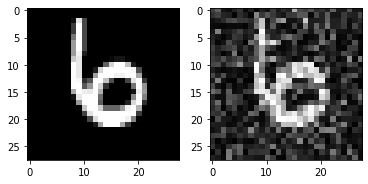

25  :  -0.7581347639377458 25
50  :  -0.7581347639377458 25
75  :  -0.7581347639377458 25
100  :  -0.7433246344079849 25
125  :  -0.7433246344079849 25
150  :  -0.7062079001381167 25
175  :  -0.7062079001381167 25
200  :  -0.6811063575192733 25
225  :  -0.6776876696330485 25
250  :  -0.670707306587708 25
275  :  -0.6334198848466297 25
300  :  -0.6328326649085199 25
325  :  -0.6328326649085199 25
350  :  -0.5896947461549851 25
375  :  -0.5905656933119616 25
400  :  -0.5905656933119616 25
425  :  -0.5497497644387013 25
450  :  -0.5497497644387013 25
475  :  -0.5497497644387013 25
500  :  -0.5497497644387013 25
525  :  -0.5383041242991535 25
550  :  -0.5239558632678161 25
575  :  -0.5223635261133359 25
600  :  -0.5025242664980955 25
625  :  -0.5025242664980955 25
650  :  -0.5025242664980955 25
675  :  -0.4996866982963518 25
700  :  -0.48745051742619205 25
725  :  -0.47308118305114555 25
750  :  -0.47308118305114555 25
775  :  -0.47308118305114555 25
800  :  -0.47051543802909457 25
825  : 

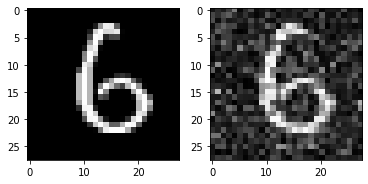

25  :  -0.7247424765716015 25
50  :  -0.7247424765716015 25
75  :  -0.667525718475688 25
100  :  -0.6509947040911523 25
125  :  -0.6314569704802102 25
150  :  -0.6314569704802102 25
175  :  -0.6209926155527978 25
200  :  -0.5319437003668996 25
225  :  -0.5296151522519639 25
250  :  -0.4377006688008811 25
275  :  -0.4376768479463157 25
300  :  -0.4376768479463157 25
325  :  -0.43664832184766267 25
350  :  -0.43661690517068774 25
375  :  -0.43661690517068774 25
400  :  -0.43661690517068774 25
425  :  -0.42645388774658066 25
450  :  -0.42645388774658066 25
475  :  -0.42645388774658066 25
500  :  -0.42645388774658066 25
525  :  -0.42645388774658066 25
550  :  -0.4012636387959124 25
575  :  -0.3943646100950673 25
600  :  -0.3945106283585522 25
625  :  -0.3911774038587873 25
650  :  -0.38974945090915636 25
675  :  -0.3708962802675395 25
700  :  -0.3716015748135253 25
725  :  -0.3582498153891437 25
750  :  -0.35636953501680124 25
775  :  -0.35638002031141003 25
800  :  -0.3496539666669839 25


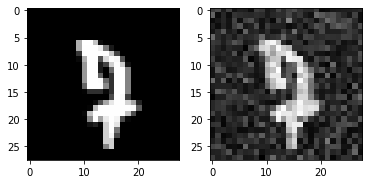

25  :  -0.6223935498808364 25
50  :  -0.6223935498808364 25
75  :  -0.5434871130397552 25
100  :  -0.5434871130397552 25
125  :  -0.48582059645962106 25
150  :  -0.4761706969337336 25
175  :  -0.4761706969337336 25
200  :  -0.4761706969337336 25
225  :  -0.4761706969337336 25
250  :  -0.4587888417902456 25
275  :  -0.44863764497748415 25
300  :  -0.44863764497748415 25
325  :  -0.44863764497748415 25
350  :  -0.4380742378205079 25
375  :  -0.44863764497748415 25
400  :  -0.44863764497748415 25
425  :  -0.44863764497748415 25
450  :  -0.4302022008324162 25
475  :  -0.4172861402721384 25
500  :  -0.40033445697442716 25
525  :  -0.40033476109713095 25
550  :  -0.40033476109713095 25
575  :  -0.40033476109713095 25
600  :  -0.40033476109713095 25
625  :  -0.3968648949120608 25
650  :  -0.39659535110254285 25
675  :  -0.39659535110254285 25
700  :  -0.39379050341086164 25
725  :  -0.39184628946405353 25
750  :  -0.39176391159251533 25
775  :  -0.39150034944951906 25
800  :  -0.3914949979901

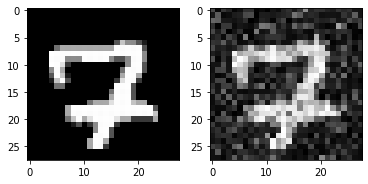

25  :  -0.7657260901665544 25
50  :  -0.7649979281334214 25
75  :  -0.7328390588178362 25
100  :  -0.7328390588178362 25
125  :  -0.7328390588178362 25
150  :  -0.7328390588178362 25
175  :  -0.7328390588178362 25
200  :  -0.7328390588178362 25
225  :  -0.7328390588178362 25
250  :  -0.7004302098447626 25
275  :  -0.7004302098447626 25
300  :  -0.7004302098447626 25
325  :  -0.7004302098447626 25
350  :  -0.6829211109009676 25
375  :  -0.6835806263889279 25
400  :  -0.6696671425780256 25
425  :  -0.6812484508393084 25
450  :  -0.6299844536180532 25
475  :  -0.6321354212505952 25
500  :  -0.6267047298721411 25
525  :  -0.6249163421370925 25
550  :  -0.6249163421370925 25
575  :  -0.6249163421370925 25
600  :  -0.6231076007694607 25
625  :  -0.6111386706114796 25
650  :  -0.6101509356954193 25
675  :  -0.5969166288320114 25
700  :  -0.59595606216156 25
725  :  -0.5850984562691328 25
750  :  -0.5743300403451972 25
775  :  -0.5743300403451972 25
800  :  -0.5662725261186374 25
825  :  -0.56

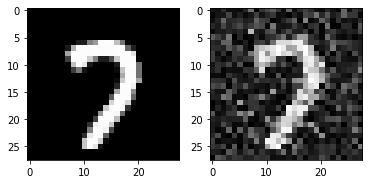

25  :  -1.6285814491816224 25
50  :  -1.365534425762662 25
75  :  -1.5254011563249996 25
100  :  -1.5254011563249996 25
125  :  -1.0244538000007768 25
150  :  -0.9509895401876252 25
175  :  -0.9973867024915006 25
200  :  -0.9973867024915006 25
225  :  -0.9973867024915006 25
250  :  -0.8459646777711045 25
275  :  -0.8215157729539524 25
300  :  -0.849056501135538 25
325  :  -0.8445430362999804 25
350  :  -0.849056501135538 25
375  :  -0.849056501135538 25
400  :  -0.849056501135538 25
425  :  -0.849056501135538 25
450  :  -0.849056501135538 25
475  :  -0.849056501135538 25
500  :  -0.8264819287169096 25
525  :  -0.820626174458102 25
550  :  -0.820626174458102 25
575  :  -0.820626174458102 25
600  :  -0.8100218547664 25
625  :  -0.804375278193449 25
650  :  -0.7978732566584577 25
675  :  -0.7863612070214252 25
700  :  -0.7796533197777693 25
725  :  -0.7741137967196294 25
750  :  -0.7600791409323757 25
775  :  -0.759137869096794 25
800  :  -0.7560548096474 25
825  :  -0.7520245829868901 25

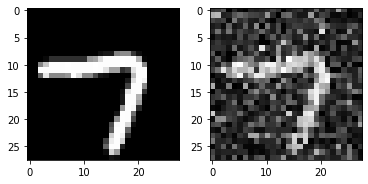

25  :  -1.1552402125671792 25
50  :  -1.0577410750110798 25
75  :  -1.1164594143841557 25
100  :  -1.0047769688901471 25
125  :  -1.0047769688901471 25
150  :  -1.0047769688901471 25
175  :  -0.9782430487415721 25
200  :  -0.9782430487415721 25
225  :  -0.9782430487415721 25
250  :  -0.9782430487415721 25
275  :  -0.9497867977791314 25
300  :  -0.9289272834967692 25
325  :  -0.8806680940773248 25
350  :  -0.8378625451979449 25
375  :  -0.8378625451979449 25
400  :  -0.8378625451979449 25
425  :  -0.8309783810328577 25
450  :  -0.8309516526749638 25
475  :  -0.8165195791767144 25
500  :  -0.8077911618167737 25
525  :  -0.8080820509546507 25
550  :  -0.7988623433795521 25
575  :  -0.8022601092303283 25
600  :  -0.7970050209251007 25
625  :  -0.7945613019775579 25
650  :  -0.7934770734159564 25
675  :  -0.788220711533373 25
700  :  -0.7880617850033604 25
725  :  -0.778549760075639 25
750  :  -0.7784207247277926 25
775  :  -0.7741715671681444 25
800  :  -0.7741715671681444 25
825  :  -0.77

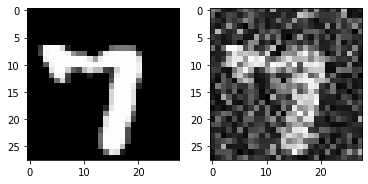

25  :  -0.6398145576209229 25
50  :  -0.6398145576209229 25
75  :  -0.6398145576209229 25
100  :  -0.6398145576209229 25
125  :  -0.6100139795115886 25
150  :  -0.6049409684756992 25
175  :  -0.569604685334667 25
200  :  -0.5618975857461634 25
225  :  -0.522982244257413 25
250  :  -0.48639212534036025 25
275  :  -0.45687969666804773 25
300  :  -0.45496718477599774 25
325  :  -0.431103408550632 25
350  :  -0.40805243360433474 25
375  :  -0.4071394875892277 25
400  :  -0.4053086389603068 25
425  :  -0.3995723720532103 25
450  :  -0.3995723720532103 25
475  :  -0.3995723720532103 25
500  :  -0.3986883553694235 25
525  :  -0.3847175039156836 25
550  :  -0.3847175039156836 25
575  :  -0.37776427328019024 25
600  :  -0.376480121966001 25
625  :  -0.368241948828834 25
650  :  -0.3649558322755412 25
675  :  -0.36312938209962875 25
700  :  -0.361806791844666 25
725  :  -0.35916546954448403 25
750  :  -0.3586795390445915 25
775  :  -0.3548470488135038 25
800  :  -0.3528382362931196 25
825  :  -0

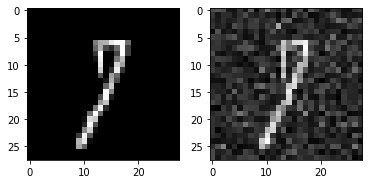

25  :  -0.7118416909734437 25
50  :  -0.7118416909734437 25
75  :  -0.7118416909734437 25
100  :  -0.7118416909734437 25
125  :  -0.7118416909734437 25
150  :  -0.7118416909734437 25
175  :  -0.7118416909734437 25
200  :  -0.7118416909734437 25
225  :  -0.7118416909734437 25
250  :  -0.7072972600813894 25
275  :  -0.6991269826379753 25
300  :  -0.6956497257664462 25
325  :  -0.6783265307820858 25
350  :  -0.6727859015540902 25
375  :  -0.6476884629545534 25
400  :  -0.6480008867078229 25
425  :  -0.6480008867078229 25
450  :  -0.6480008867078229 25
475  :  -0.6480008867078229 25
500  :  -0.6480008867078229 25
525  :  -0.6480008867078229 25
550  :  -0.6480008867078229 25
575  :  -0.6480008867078229 25
600  :  -0.6480008867078229 25
625  :  -0.6480008867078229 25
650  :  -0.6480008867078229 25
675  :  -0.6480008867078229 25
700  :  -0.6480008867078229 25
725  :  -0.6480008867078229 25
750  :  -0.6480008867078229 25
775  :  -0.6480008867078229 25
800  :  -0.6480008867078229 25
825  :  -0.

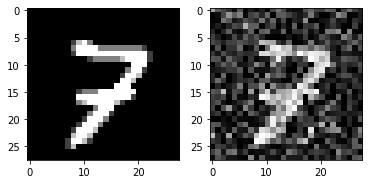

25  :  -0.8719778253207986 25
50  :  -0.7706494509184074 25
75  :  -0.7771921086989859 25
100  :  -0.7537761715645213 25
125  :  -0.738195608334552 25
150  :  -0.7483844352299969 25
175  :  -0.6448583264682297 25
200  :  -0.6525895653711526 25
225  :  -0.6525895653711526 25
250  :  -0.6525895653711526 25
275  :  -0.6439829813618405 25
300  :  -0.6408148311487383 25
325  :  -0.6339831174616506 25
350  :  -0.5983406372148548 25
375  :  -0.5959388416237295 25
400  :  -0.5959388416237295 25
425  :  -0.5959388416237295 25
450  :  -0.5959388416237295 25
475  :  -0.5959388416237295 25
500  :  -0.5959388416237295 25
525  :  -0.5298837382820392 25
550  :  -0.5282888702705772 25
575  :  -0.5282892269651573 25
600  :  -0.5282892269651573 25
625  :  -0.5282892269651573 25
650  :  -0.5282892269651573 25
675  :  -0.5249291660289508 25
700  :  -0.5238058169685764 25
725  :  -0.5238516171784451 25
750  :  -0.5085919934151413 25
775  :  -0.5085745564821436 25
800  :  -0.5079467964043147 25
825  :  -0.5

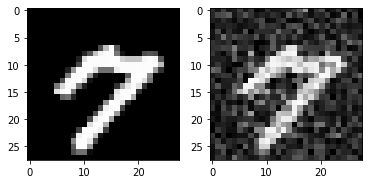

25  :  -0.7651126501015342 25
50  :  -0.7651126501015342 25
75  :  -0.7651126501015342 25
100  :  -0.7651126501015342 25
125  :  -0.7651126501015342 25
150  :  -0.7651126501015342 25
175  :  -0.7651126501015342 25
200  :  -0.7651126501015342 25
225  :  -0.7651126501015342 25
250  :  -0.7441337709121536 25
275  :  -0.7219701019144353 25
300  :  -0.6049548819691304 25
325  :  -0.607178507535606 25
350  :  -0.6011781121436672 25
375  :  -0.6065231847926662 25
400  :  -0.6065231847926662 25
425  :  -0.6065231847926662 25
450  :  -0.6065231847926662 25
475  :  -0.6065231847926662 25
500  :  -0.6065231847926662 25
525  :  -0.6065231847926662 25
550  :  -0.6065231847926662 25
575  :  -0.6065231847926662 25
600  :  -0.5650435624221621 25
625  :  -0.5613227375916408 25
650  :  -0.5613227375916408 25
675  :  -0.5613227375916408 25
700  :  -0.5578460403988141 25
725  :  -0.5567490540331315 25
750  :  -0.5484694755417969 25
775  :  -0.543676035237799 25
800  :  -0.5352394858786729 25
825  :  -0.53

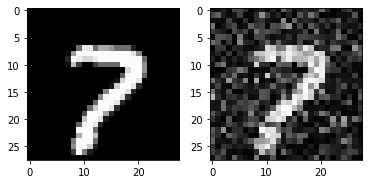

25  :  -0.82476574273984 25
50  :  -0.8086423300170886 25
75  :  -0.8135056855446812 25
100  :  -0.8127838580077631 25
125  :  -0.790331768990129 25
150  :  -0.8065881454230652 25
175  :  -0.8065881454230652 25
200  :  -0.7831719291191832 25
225  :  -0.7831719291191832 25
250  :  -0.7831719291191832 25
275  :  -0.7831719291191832 25
300  :  -0.7831719291191832 25
325  :  -0.7713380814036306 25
350  :  -0.7662805415619749 25
375  :  -0.7641954997609728 25
400  :  -0.7231864673808712 25
425  :  -0.7233800836283923 25
450  :  -0.7171472601064435 25
475  :  -0.7161911092619717 25
500  :  -0.6897880010067223 25
525  :  -0.669480114263757 25
550  :  -0.6725771073189637 25
575  :  -0.6725771073189637 25
600  :  -0.6725771073189637 25
625  :  -0.6725771073189637 25
650  :  -0.6392959572916603 25
675  :  -0.6449557026732553 25
700  :  -0.6469583488572661 25
725  :  -0.6340446947726781 25
750  :  -0.6191348773762222 25
775  :  -0.6190187497752204 25
800  :  -0.6170788851088778 25
825  :  -0.6100

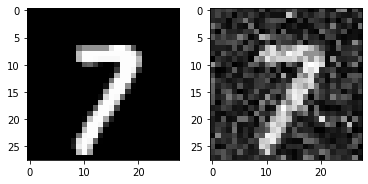

25  :  -0.7728153121406709 25
50  :  -0.7539022788201732 25
75  :  -0.675051507305455 25
100  :  -0.6815499998248091 25
125  :  -0.6815499998248091 25
150  :  -0.6815499998248091 25
175  :  -0.6815499998248091 25
200  :  -0.6815499998248091 25
225  :  -0.6815499998248091 25
250  :  -0.6538226490986447 25
275  :  -0.6632627282735288 25
300  :  -0.6505015253586532 25
325  :  -0.6433488782131331 25
350  :  -0.6329036549938409 25
375  :  -0.6338040203261395 25
400  :  -0.6338040203261395 25
425  :  -0.6248780252757764 25
450  :  -0.6217547776704893 25
475  :  -0.6217547776704893 25
500  :  -0.6166157125584792 25
525  :  -0.6166157125584792 25
550  :  -0.6166157125584792 25
575  :  -0.5946428224071099 25
600  :  -0.598718878099531 25
625  :  -0.5994137420945107 25
650  :  -0.5994137420945107 25
675  :  -0.5807917272426459 25
700  :  -0.5811844450272003 25
725  :  -0.5811844450272003 25
750  :  -0.5811844450272003 25
775  :  -0.5730782179193041 25
800  :  -0.5707089567209125 25
825  :  -0.56

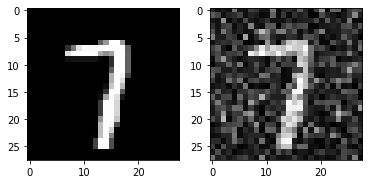

25  :  -0.7474214934619512 25
50  :  -0.7474214934619512 25
75  :  -0.7474214934619512 25
100  :  -0.7460636996897205 25
125  :  -0.7448336805299283 25
150  :  -0.7448336805299283 25
175  :  -0.7448336805299283 25
200  :  -0.7448336805299283 25
225  :  -0.7434880017295733 25
250  :  -0.7282187059675036 25
275  :  -0.7205955756635538 25
300  :  -0.6964547837141368 25
325  :  -0.6877163239349378 25
350  :  -0.6693658659009578 25
375  :  -0.6182081766572851 25
400  :  -0.607700977151655 25
425  :  -0.607700977151655 25
450  :  -0.607700977151655 25
475  :  -0.607700977151655 25
500  :  -0.5838641529819435 25
525  :  -0.580995833230419 25
550  :  -0.580995833230419 25
575  :  -0.580995833230419 25
600  :  -0.580995833230419 25
625  :  -0.5681581465980152 25
650  :  -0.5546961495269698 25
675  :  -0.554525546315586 25
700  :  -0.554525546315586 25
725  :  -0.554525546315586 25
750  :  -0.5462310461525679 25
775  :  -0.541941386523989 25
800  :  -0.5394072980472284 25
825  :  -0.538594976065

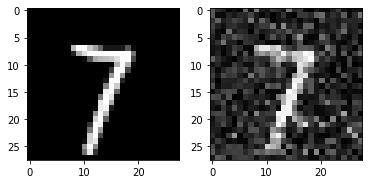

25  :  -0.7527502149731942 25
50  :  -0.7527502149731942 25
75  :  -0.7450593546633204 25
100  :  -0.6962300067512828 25
125  :  -0.6966491663295542 25
150  :  -0.6724514820097698 25
175  :  -0.6699081823278186 25
200  :  -0.665159349357606 25
225  :  -0.6250415088254886 25
250  :  -0.6061244083483184 25
275  :  -0.599978021303706 25
300  :  -0.6053723497418027 25
325  :  -0.6053723497418027 25
350  :  -0.6053723497418027 25
375  :  -0.6053723497418027 25
400  :  -0.6036933890845315 25
425  :  -0.5927417077056485 25
450  :  -0.5966530700709012 25
475  :  -0.5916274314052448 25
500  :  -0.5918421787909285 25
525  :  -0.5918421787909285 25
550  :  -0.5918421787909285 25
575  :  -0.5829289608044572 25
600  :  -0.5724511682053797 25
625  :  -0.5756169342699993 25
650  :  -0.5756169342699993 25
675  :  -0.5756169342699993 25
700  :  -0.5713014302424404 25
725  :  -0.5664682327855188 25
750  :  -0.5633758960494724 25
775  :  -0.5634033882901173 25
800  :  -0.5634033882901173 25
825  :  -0.56

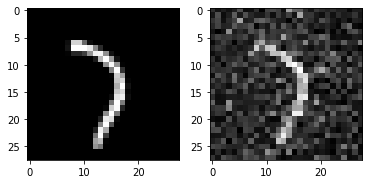

25  :  -1.649457457786171 25
50  :  -1.5971221645705744 25
75  :  -1.5288315802687704 25
100  :  -1.5225056655108156 25
125  :  -1.4953912260429032 25
150  :  -1.394847764469973 25
175  :  -1.394847764469973 25
200  :  -1.394847764469973 25
225  :  -1.3797102943231345 25
250  :  -1.3592367139945303 25
275  :  -1.3592367139945303 25
300  :  -1.3592367139945303 25
325  :  -1.3592367139945303 25
350  :  -1.3592367139945303 25
375  :  -1.3592367139945303 25
400  :  -1.3562858549404413 25
425  :  -1.3384481428121324 25
450  :  -1.3309794276601334 25
475  :  -1.330963955093365 25
500  :  -1.3222975621382873 25
525  :  -1.3155997458713178 25
550  :  -1.3124120957890604 25
575  :  -1.312349961744873 25
600  :  -1.300227763406929 25
625  :  -1.296700393098698 25
650  :  -1.296700393098698 25
675  :  -1.2946125087784788 25
700  :  -1.2928269242844577 25
725  :  -1.2866629138726629 25
750  :  -1.2865243158389967 25
775  :  -1.2850556383327287 25
800  :  -1.2819928018320954 25
825  :  -1.281992801

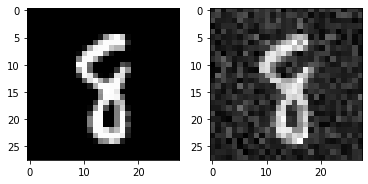

25  :  -1.6135548837011144 25
50  :  -1.567662479117161 25
75  :  -1.5559823458857331 25
100  :  -1.5559823458857331 25
125  :  -1.5208704169071048 25
150  :  -1.5208704169071048 25
175  :  -1.5154041573841524 25
200  :  -1.4781156859317113 25
225  :  -1.4781156859317113 25
250  :  -1.4754676752230347 25
275  :  -1.4752079192723864 25
300  :  -1.465430614004591 25
325  :  -1.4523400417148116 25
350  :  -1.4487108598689291 25
375  :  -1.4156884294110976 25
400  :  -1.4094395722513955 25
425  :  -1.4064236741292002 25
450  :  -1.3988120979112921 25
475  :  -1.3805126421330804 25
500  :  -1.3636215194272419 25
525  :  -1.3636215194272419 25
550  :  -1.353833736510817 25
575  :  -1.3493920356490072 25
600  :  -1.349368297203724 25
625  :  -1.349368297203724 25
650  :  -1.3460634104044793 25
675  :  -1.3418457612482353 25
700  :  -1.3371229995520988 25
725  :  -1.3371108032800525 25
750  :  -1.3371108032800525 25
775  :  -1.3368359166593264 25
800  :  -1.3355219409512396 25
825  :  -1.33507

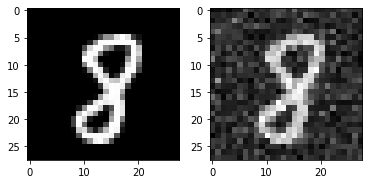

25  :  -1.6637577283106506 25
50  :  -1.6295837636989814 25
75  :  -1.615697060066269 25
100  :  -1.563577638740741 25
125  :  -1.5247108602287365 25
150  :  -1.5181820309105294 25
175  :  -1.485724066504222 25
200  :  -1.485724066504222 25
225  :  -1.471235484248151 25
250  :  -1.434410431948156 25
275  :  -1.4010374679796063 25
300  :  -1.3997503333911405 25
325  :  -1.366570532951431 25
350  :  -1.366570532951431 25
375  :  -1.366570532951431 25
400  :  -1.366570532951431 25
425  :  -1.366570532951431 25
450  :  -1.3486938318009627 25
475  :  -1.325055469969609 25
500  :  -1.3233352471397168 25
525  :  -1.3233352393123772 25
550  :  -1.3233352393123772 25
575  :  -1.316977454543745 25
600  :  -1.316977454543745 25
625  :  -1.3141463732914085 25
650  :  -1.3138737324799379 25
675  :  -1.3131897348789545 25
700  :  -1.3122947227101878 25
725  :  -1.311299176018886 25
750  :  -1.308761921039933 25
775  :  -1.308761921039933 25
800  :  -1.3086843448900742 25
825  :  -1.3059564881404535 

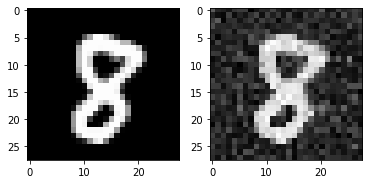

25  :  -1.6554714612197394 25
50  :  -1.5591447128001552 25
75  :  -1.5399525744391138 25
100  :  -1.5310588608590476 25
125  :  -1.4840063448881087 25
150  :  -1.4614019532447253 25
175  :  -1.4248401420142096 25
200  :  -1.4248401420142096 25
225  :  -1.4248401420142096 25
250  :  -1.405861050626228 25
275  :  -1.3798805626899369 25
300  :  -1.3645221866967812 25
325  :  -1.3402934882327475 25
350  :  -1.3402934882327475 25
375  :  -1.3402934882327475 25
400  :  -1.338386857319572 25
425  :  -1.3382496561730273 25
450  :  -1.3324905080815515 25
475  :  -1.330992583825025 25
500  :  -1.322321270430198 25
525  :  -1.3099894301948516 25
550  :  -1.3099894301948516 25
575  :  -1.3099894301948516 25
600  :  -1.3051478500262221 25
625  :  -1.305143934193875 25
650  :  -1.301986374005426 25
675  :  -1.301986374005426 25
700  :  -1.3008667512966856 25
725  :  -1.3001817375800917 25
750  :  -1.2986497954365666 25
775  :  -1.2932319190814683 25
800  :  -1.2932319190814683 25
825  :  -1.2905508

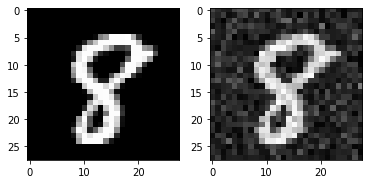

25  :  -1.6016289547243445 25
50  :  -1.6016289547243445 25
75  :  -1.5475213938227566 25
100  :  -1.5475213938227566 25
125  :  -1.5407271713662996 25
150  :  -1.5394937408274032 25
175  :  -1.5013767634668576 25
200  :  -1.4871883136313526 25
225  :  -1.4785926739541058 25
250  :  -1.4233628901257447 25
275  :  -1.4233628901257447 25
300  :  -1.4098918374861327 25
325  :  -1.4048564043725698 25
350  :  -1.3933627423823651 25
375  :  -1.3869140521637386 25
400  :  -1.3869140521637386 25
425  :  -1.3738357676704303 25
450  :  -1.3585764667523899 25
475  :  -1.3585764667523899 25
500  :  -1.3585764667523899 25
525  :  -1.3556492973473084 25
550  :  -1.3527519785945175 25
575  :  -1.3392650341371444 25
600  :  -1.3392650341371444 25
625  :  -1.3374749851257755 25
650  :  -1.3299688333120927 25
675  :  -1.3299686844338274 25
700  :  -1.3299686844338274 25
725  :  -1.325526181699948 25
750  :  -1.3221192517022509 25
775  :  -1.319648102608999 25
800  :  -1.3195035311522947 25
825  :  -1.31

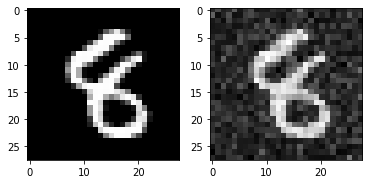

25  :  -1.505928036306721 25
50  :  -1.505928036306721 25
75  :  -1.505928036306721 25
100  :  -1.4596723054929714 25
125  :  -1.4523733509175503 25
150  :  -1.4523733509175503 25
175  :  -1.4523733509175503 25
200  :  -1.4343658473122705 25
225  :  -1.428149954396711 25
250  :  -1.4281147661280105 25
275  :  -1.4155821279538046 25
300  :  -1.3896902838520069 25
325  :  -1.3893749864992833 25
350  :  -1.3805073448529124 25
375  :  -1.3518039422471184 25
400  :  -1.3518039422471184 25
425  :  -1.3518039422471184 25
450  :  -1.3518039422471184 25
475  :  -1.3476976120423085 25
500  :  -1.3359687145218206 25
525  :  -1.335965348694997 25
550  :  -1.335965348694997 25
575  :  -1.335965348694997 25
600  :  -1.3347092625846146 25
625  :  -1.3244532327154146 25
650  :  -1.3232862471912932 25
675  :  -1.3210610133907454 25
700  :  -1.3168295604391345 25
725  :  -1.3168295604391345 25
750  :  -1.315446094389809 25
775  :  -1.3149522218055967 25
800  :  -1.3105573161393225 25
825  :  -1.30960773

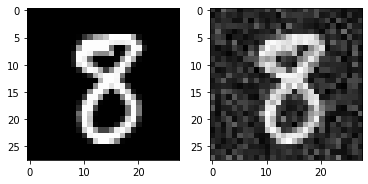

25  :  -1.6779524221438618 25
50  :  -1.5264535062230062 25
75  :  -1.517189443025902 25
100  :  -1.517189443025902 25
125  :  -1.517189443025902 25
150  :  -1.5012046097717486 25
175  :  -1.4695064747457671 25
200  :  -1.456528404818655 25
225  :  -1.4518237717109908 25
250  :  -1.4372617750449541 25
275  :  -1.4166006537458515 25
300  :  -1.393860264245537 25
325  :  -1.3788591515324988 25
350  :  -1.3788591515324988 25
375  :  -1.3738205495866513 25
400  :  -1.3738195089293201 25
425  :  -1.3489534483927335 25
450  :  -1.3489534483927335 25
475  :  -1.3489534483927335 25
500  :  -1.3489534483927335 25
525  :  -1.348488254041148 25
550  :  -1.348487657329392 25
575  :  -1.347482198153633 25
600  :  -1.3467923744776575 25
625  :  -1.342716847761285 25
650  :  -1.3404135567565292 25
675  :  -1.340284994599014 25
700  :  -1.3397825448017646 25
725  :  -1.3371420680598836 25
750  :  -1.3345548750376213 25
775  :  -1.334127226313955 25
800  :  -1.3320525043321358 25
825  :  -1.33143834102

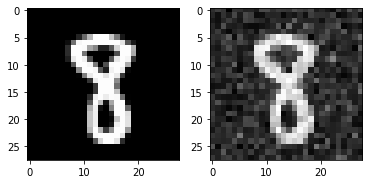

25  :  -0.8117954430378997 25
50  :  -0.8117954430378997 25
75  :  -0.7418813200636643 25
100  :  -0.753796421506226 25
125  :  -0.7945619735835183 25
150  :  -0.7505115162660241 25
175  :  -0.7505115162660241 25
200  :  -0.71881377003456 25
225  :  -0.71881377003456 25
250  :  -0.71881377003456 25
275  :  -0.71881377003456 25
300  :  -0.6771325432788229 25
325  :  -0.679072126479644 25
350  :  -0.6570267446898368 25
375  :  -0.6570267446898368 25
400  :  -0.6570267446898368 25
425  :  -0.6570267446898368 25
450  :  -0.644746294863962 25
475  :  -0.6446569671970321 25
500  :  -0.6377085389557708 25
525  :  -0.6214579158060338 25
550  :  -0.6039075508321741 25
575  :  -0.6037191541947475 25
600  :  -0.6037191541947475 25
625  :  -0.6037191541947475 25
650  :  -0.6037191541947475 25
675  :  -0.5978532125349576 25
700  :  -0.5978532125349576 25
725  :  -0.5893696137103275 25
750  :  -0.5893747079119547 25
775  :  -0.5876861181003084 25
800  :  -0.5816437154479619 25
825  :  -0.58047585755

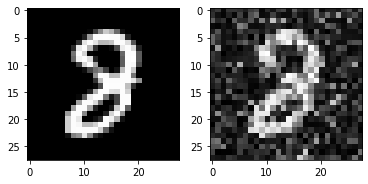

25  :  -1.6666231074936924 25
50  :  -1.5717248654686133 25
75  :  -1.5305152489272034 25
100  :  -1.4780125876948784 25
125  :  -1.4780125876948784 25
150  :  -1.4667088600138127 25
175  :  -1.453669053264021 25
200  :  -1.4386526995106372 25
225  :  -1.4020576842900443 25
250  :  -1.4019545525167239 25
275  :  -1.3933366027771275 25
300  :  -1.3787371554955963 25
325  :  -1.3677907230066855 25
350  :  -1.341462641263787 25
375  :  -1.3201913754804966 25
400  :  -1.3201913754804966 25
425  :  -1.3038272247520932 25
450  :  -1.302294337861058 25
475  :  -1.3019113345991475 25
500  :  -1.3019105847736414 25
525  :  -1.3011298878532336 25
550  :  -1.2993630813336914 25
575  :  -1.295422139927723 25
600  :  -1.288643523748577 25
625  :  -1.288643523748577 25
650  :  -1.288643523748577 25
675  :  -1.286014536969607 25
700  :  -1.286014536969607 25
725  :  -1.286014536969607 25
750  :  -1.286014536969607 25
775  :  -1.2857640265890078 25
800  :  -1.2804339120778143 25
825  :  -1.27767245375

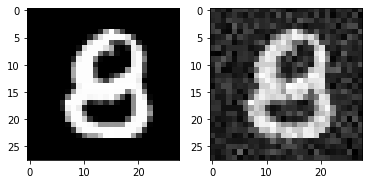

25  :  -1.6457986659638841 25
50  :  -1.6035909965379025 25
75  :  -1.533521228809993 25
100  :  -1.5091927659425355 25
125  :  -1.4739956096497724 25
150  :  -1.4702768570295264 25
175  :  -1.4642214791127757 25
200  :  -1.427802108428635 25
225  :  -1.4260587345761464 25
250  :  -1.4196656850370806 25
275  :  -1.3962795937750954 25
300  :  -1.396255968034677 25
325  :  -1.3724643294443766 25
350  :  -1.3723912891982426 25
375  :  -1.3708800006950568 25
400  :  -1.3613621311604125 25
425  :  -1.3483027302451087 25
450  :  -1.3483019762833761 25
475  :  -1.332337750712647 25
500  :  -1.332337750712647 25
525  :  -1.332337750712647 25
550  :  -1.327359731395217 25
575  :  -1.3178424306704382 25
600  :  -1.3157259069278433 25
625  :  -1.3157259069278433 25
650  :  -1.3157259069278433 25
675  :  -1.312278233603164 25
700  :  -1.312278233603164 25
725  :  -1.309389088806832 25
750  :  -1.3083227973620883 25
775  :  -1.3076768769475686 25
800  :  -1.3053603916013004 25
825  :  -1.3041042556

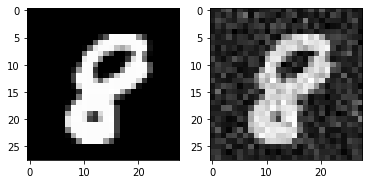

25  :  -1.6201103271757145 25
50  :  -1.612711511699025 25
75  :  -1.5765556303708241 25
100  :  -1.5330840469925011 25
125  :  -1.486117609817251 25
150  :  -1.4793004602224575 25
175  :  -1.4554044432772564 25
200  :  -1.4297724371622658 25
225  :  -1.428490274026283 25
250  :  -1.4284426601358178 25
275  :  -1.3924143783047098 25
300  :  -1.3881817634813425 25
325  :  -1.356938249207625 25
350  :  -1.3535293926246643 25
375  :  -1.3364884249699993 25
400  :  -1.3364884249699993 25
425  :  -1.3364884249699993 25
450  :  -1.3309246001615374 25
475  :  -1.3309246001615374 25
500  :  -1.3192093589788432 25
525  :  -1.317332331291396 25
550  :  -1.317332331291396 25
575  :  -1.3144787354427407 25
600  :  -1.3093903604657258 25
625  :  -1.3054025066167254 25
650  :  -1.3054025066167254 25
675  :  -1.2985038271263192 25
700  :  -1.2985038271263192 25
725  :  -1.2985038271263192 25
750  :  -1.2985038271263192 25
775  :  -1.2973810728754178 25
800  :  -1.2973810728754178 25
825  :  -1.296654

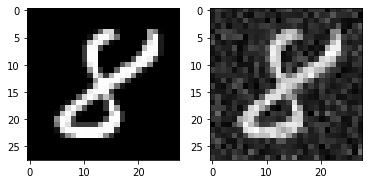

25  :  -1.661694354540417 25
50  :  -1.6014661324056783 25
75  :  -1.5905345011623142 25
100  :  -1.567118702882133 25
125  :  -1.5500100762059723 25
150  :  -1.5465169958851415 25
175  :  -1.5465169958851415 25
200  :  -1.5162090995499131 25
225  :  -1.500475309670023 25
250  :  -1.4171746570910653 25
275  :  -1.4171746570910653 25
300  :  -1.4171746570910653 25
325  :  -1.3863007663240328 25
350  :  -1.379102937467123 25
375  :  -1.379102937467123 25
400  :  -1.379102937467123 25
425  :  -1.379102937467123 25
450  :  -1.379102937467123 25
475  :  -1.36950503275939 25
500  :  -1.3531801509437646 25
525  :  -1.353178363731883 25
550  :  -1.3406763178534793 25
575  :  -1.3376328268331399 25
600  :  -1.3297395481815109 25
625  :  -1.3297201724648424 25
650  :  -1.3297201724648424 25
675  :  -1.3229842069550206 25
700  :  -1.3209041899866447 25
725  :  -1.319957895678608 25
750  :  -1.3158855747380231 25
775  :  -1.3158792045992347 25
800  :  -1.3158792045992347 25
825  :  -1.313939083213

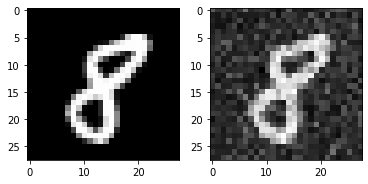

25  :  -0.7415939520505042 25
50  :  -0.7373235522627717 25
75  :  -0.7372569814382932 25
100  :  -0.7372569814382932 25
125  :  -0.7216314637623029 25
150  :  -0.703299812497586 25
175  :  -0.682545629944455 25
200  :  -0.6416104595813363 25
225  :  -0.6416104595813363 25
250  :  -0.6282308848330562 25
275  :  -0.6282308848330562 25
300  :  -0.6022864737366014 25
325  :  -0.5904507397103171 25
350  :  -0.5802531754008944 25
375  :  -0.5794995914158654 25
400  :  -0.5794995914158654 25
425  :  -0.5794995914158654 25
450  :  -0.5752290718967696 25
475  :  -0.5433264471412163 25
500  :  -0.5407462067216393 25
525  :  -0.5392603551807487 25
550  :  -0.5218785161010968 25
575  :  -0.5218785161010968 25
600  :  -0.5218785161010968 25
625  :  -0.5153619476438118 25
650  :  -0.5097051742883476 25
675  :  -0.5059000361958494 25
700  :  -0.504975758738163 25
725  :  -0.5031988098963767 25
750  :  -0.5031047783999684 25
775  :  -0.5001285575817137 25
800  :  -0.49466577591920546 25
825  :  -0.49

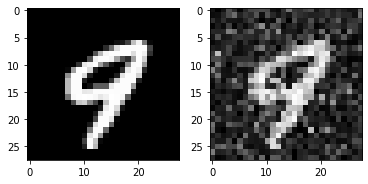

25  :  -0.7310944258727694 25
50  :  -0.7310944258727694 25
75  :  -0.7298951882732811 25
100  :  -0.72492320407419 25
125  :  -0.7020450152713156 25
150  :  -0.6909077756718236 25
175  :  -0.6863712211126023 25
200  :  -0.6835128655923604 25
225  :  -0.6522516003430001 25
250  :  -0.6632737107528983 25
275  :  -0.5994783684550522 25
300  :  -0.5994476700054028 25
325  :  -0.5565702344784151 25
350  :  -0.5585734573772705 25
375  :  -0.5585734573772705 25
400  :  -0.5585734573772705 25
425  :  -0.5585734573772705 25
450  :  -0.5585734573772705 25
475  :  -0.5585734573772705 25
500  :  -0.5585734573772705 25
525  :  -0.5585734573772705 25
550  :  -0.5585734573772705 25
575  :  -0.5585734573772705 25
600  :  -0.5585734573772705 25
625  :  -0.5585734573772705 25
650  :  -0.5583066705932058 25
675  :  -0.5583066705932058 25
700  :  -0.5583066705932058 25
725  :  -0.530056304855612 25
750  :  -0.5300349218916345 25
775  :  -0.5300349218916345 25
800  :  -0.5300349218916345 25
825  :  -0.530

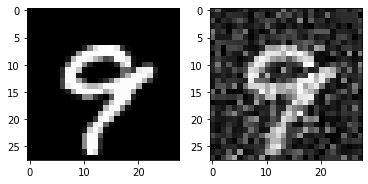

25  :  -0.7337166217116027 25
50  :  -0.7337166217116027 25
75  :  -0.7045303445380846 25
100  :  -0.6883631464047353 25
125  :  -0.6180282283617877 25
150  :  -0.6181099361478464 25
175  :  -0.6181099361478464 25
200  :  -0.6181099361478464 25
225  :  -0.6067388108187619 25
250  :  -0.6128267127471014 25
275  :  -0.5890817789295868 25
300  :  -0.5976571038832055 25
325  :  -0.5794305244229006 25
350  :  -0.5715363578944403 25
375  :  -0.5642844486074277 25
400  :  -0.554709968513029 25
425  :  -0.5546422182659818 25
450  :  -0.5499360028251188 25
475  :  -0.5468071057050454 25
500  :  -0.5468071057050454 25
525  :  -0.5323740411104192 25
550  :  -0.5303886961363802 25
575  :  -0.5239728783687916 25
600  :  -0.5136952242865545 25
625  :  -0.5060474319259018 25
650  :  -0.5006708665453827 25
675  :  -0.500680078519303 25
700  :  -0.4959507233492446 25
725  :  -0.4917414813916632 25
750  :  -0.4917414813916632 25
775  :  -0.4917414813916632 25
800  :  -0.4908026575953427 25
825  :  -0.48

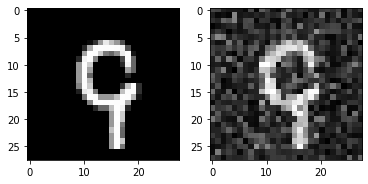

25  :  -0.7950714330821207 25
50  :  -0.7950714330821207 25
75  :  -0.7950714330821207 25
100  :  -0.7394005278203744 25
125  :  -0.7523023249358243 25
150  :  -0.7523023249358243 25
175  :  -0.7523023249358243 25
200  :  -0.7523023249358243 25
225  :  -0.7317779699194582 25
250  :  -0.7224394480817737 25
275  :  -0.713560039243784 25
300  :  -0.6917950488885829 25
325  :  -0.6920227640668948 25
350  :  -0.6920227640668948 25
375  :  -0.6920227640668948 25
400  :  -0.6693016163413188 25
425  :  -0.6693016163413188 25
450  :  -0.658492077460616 25
475  :  -0.6563344316492077 25
500  :  -0.6374863634033923 25
525  :  -0.6343763176303698 25
550  :  -0.6023238580747694 25
575  :  -0.6023238580747694 25
600  :  -0.6023238580747694 25
625  :  -0.5949519757431256 25
650  :  -0.5956145086440559 25
675  :  -0.5797181447253754 25
700  :  -0.581062589868685 25
725  :  -0.5655811298674216 25
750  :  -0.5669149521365224 25
775  :  -0.5560907980417897 25
800  :  -0.5474937824102388 25
825  :  -0.544

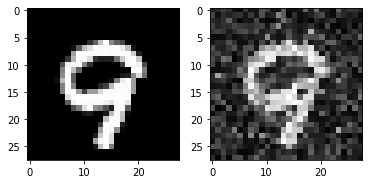

25  :  -0.7699862380297997 25
50  :  -0.7699862380297997 25
75  :  -0.7518829950901182 25
100  :  -0.7516458723159007 25
125  :  -0.7416048192968345 25
150  :  -0.6976074064510756 25
175  :  -0.6976074064510756 25
200  :  -0.6956792579484383 25
225  :  -0.6955284005011226 25
250  :  -0.6955284005011226 25
275  :  -0.6955284005011226 25
300  :  -0.6955284005011226 25
325  :  -0.6675282054576828 25
350  :  -0.6675282054576828 25
375  :  -0.6675282054576828 25
400  :  -0.6063887725143535 25
425  :  -0.6080523408342844 25
450  :  -0.6080523408342844 25
475  :  -0.6080523408342844 25
500  :  -0.6080523408342844 25
525  :  -0.6080523408342844 25
550  :  -0.6080523408342844 25
575  :  -0.6080523408342844 25
600  :  -0.5994230980350275 25
625  :  -0.5995893968285204 25
650  :  -0.5984416383468607 25
675  :  -0.5862505757296681 25
700  :  -0.5788994483808525 25
725  :  -0.578849113448141 25
750  :  -0.5508172279563015 25
775  :  -0.5508172279563015 25
800  :  -0.5362809648276674 25
825  :  -0.5

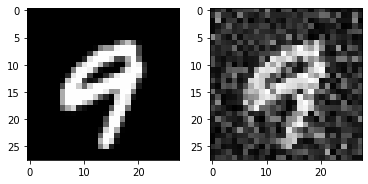

25  :  -0.7084114432591619 25
50  :  -0.7084114432591619 25
75  :  -0.5599394491346394 25
100  :  -0.5545511667405083 25
125  :  -0.5545511667405083 25
150  :  -0.5545511667405083 25
175  :  -0.5545511667405083 25
200  :  -0.5345569735362963 25
225  :  -0.5353041461816703 25
250  :  -0.4869723867844039 25
275  :  -0.4869723867844039 25
300  :  -0.4614912089564731 25
325  :  -0.4542883229553921 25
350  :  -0.45456122345948113 25
375  :  -0.45456122345948113 25
400  :  -0.4253052862569048 25
425  :  -0.41706477947498455 25
450  :  -0.40776706402433116 25
475  :  -0.40776706402433116 25
500  :  -0.40776706402433116 25
525  :  -0.40776706402433116 25
550  :  -0.40776706402433116 25
575  :  -0.40776706402433116 25
600  :  -0.40776706402433116 25
625  :  -0.40776706402433116 25
650  :  -0.40714352332573134 25
675  :  -0.4041217064609506 25
700  :  -0.3981494708979313 25
725  :  -0.3895189448509153 25
750  :  -0.3866839696382014 25
775  :  -0.3866839696382014 25
800  :  -0.37941461737737114 2

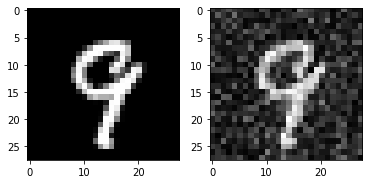

25  :  -0.7003111195287004 25
50  :  -0.6436352273723223 25
75  :  -0.6350829302271865 25
100  :  -0.6350829302271865 25
125  :  -0.6350829302271865 25
150  :  -0.6047554189866926 25
175  :  -0.5862869065776539 25
200  :  -0.5758225904105647 25
225  :  -0.5758225904105647 25
250  :  -0.5758225904105647 25
275  :  -0.5680184849841452 25
300  :  -0.5680184849841452 25
325  :  -0.5680184849841452 25
350  :  -0.5334939242286536 25
375  :  -0.5341756889447777 25
400  :  -0.5221988027870936 25
425  :  -0.52663148506506 25
450  :  -0.5054385503635964 25
475  :  -0.5055968343203048 25
500  :  -0.5001456019307383 25
525  :  -0.4924197704719341 25
550  :  -0.48507767377362476 25
575  :  -0.478878888681336 25
600  :  -0.478878888681336 25
625  :  -0.4747794575545877 25
650  :  -0.4737660825829191 25
675  :  -0.4737432929172223 25
700  :  -0.4737468388817717 25
725  :  -0.4737468388817717 25
750  :  -0.4695644856797797 25
775  :  -0.4693829861923162 25
800  :  -0.4639923355289872 25
825  :  -0.463

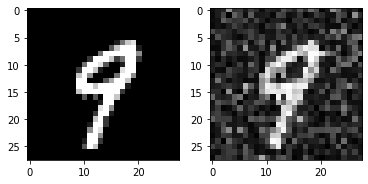

25  :  -0.6913348038823071 25
50  :  -0.5579788136288457 25
75  :  -0.5571416703765106 25
100  :  -0.5571416703765106 25
125  :  -0.5571416703765106 25
150  :  -0.5571416703765106 25
175  :  -0.5352708010024378 25
200  :  -0.5316384356362087 25
225  :  -0.5316384356362087 25
250  :  -0.5061592031451919 25
275  :  -0.5056428421645629 25
300  :  -0.5056428421645629 25
325  :  -0.5056428421645629 25
350  :  -0.5056428421645629 25
375  :  -0.5056428421645629 25
400  :  -0.5056428421645629 25
425  :  -0.4789154585468769 25
450  :  -0.46298596726210395 25
475  :  -0.46251643293791933 25
500  :  -0.46141375614670277 25
525  :  -0.46251643293791933 25
550  :  -0.4594284412548816 25
575  :  -0.4559561697167068 25
600  :  -0.4512595503561243 25
625  :  -0.43412263431033304 25
650  :  -0.4345523041649466 25
675  :  -0.4343730672960432 25
700  :  -0.4343823720034776 25
725  :  -0.42411540804470926 25
750  :  -0.4206599084021643 25
775  :  -0.41500994077796316 25
800  :  -0.41507095704919694 25
825

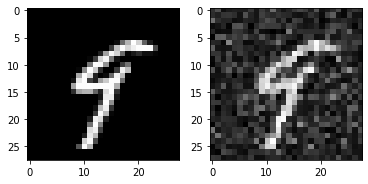

25  :  -1.061265849952349 25
50  :  -0.8737668428052738 25
75  :  -0.8255924492046813 25
100  :  -0.8255924492046813 25
125  :  -0.8098291231645689 25
150  :  -0.8098291231645689 25
175  :  -0.8060747365672325 25
200  :  -0.8055023320089119 25
225  :  -0.7926994815785666 25
250  :  -0.7704144096379115 25
275  :  -0.7618657804741111 25
300  :  -0.7618657804741111 25
325  :  -0.7618657804741111 25
350  :  -0.7618657804741111 25
375  :  -0.7609071983525926 25
400  :  -0.7558656173507059 25
425  :  -0.7415914920943651 25
450  :  -0.7299198089964092 25
475  :  -0.7265398358320732 25
500  :  -0.7267586276933815 25
525  :  -0.7270158352193199 25
550  :  -0.7189864512752395 25
575  :  -0.7188505264301923 25
600  :  -0.7178229763385406 25
625  :  -0.696892673868595 25
650  :  -0.6939246702945876 25
675  :  -0.6688243644110141 25
700  :  -0.6706973537629788 25
725  :  -0.6651347973070436 25
750  :  -0.6651347973070436 25
775  :  -0.6438751933028743 25
800  :  -0.6435436482313321 25
825  :  -0.63

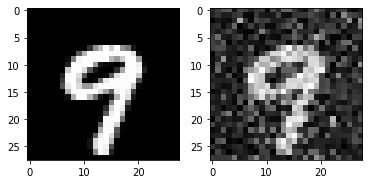

25  :  -0.6861245482300304 25
50  :  -0.6861245482300304 25
75  :  -0.6861245482300304 25
100  :  -0.6861245482300304 25
125  :  -0.6861245482300304 25
150  :  -0.6714070254038966 25
175  :  -0.6638287365095399 25
200  :  -0.6638287365095399 25
225  :  -0.6446337771092494 25
250  :  -0.6151193158048567 25
275  :  -0.5953407785308575 25
300  :  -0.580666669063719 25
325  :  -0.5736747953363597 25
350  :  -0.5736747953363597 25
375  :  -0.5555830179467156 25
400  :  -0.5555830179467156 25
425  :  -0.5499513889792487 25
450  :  -0.5430465511097506 25
475  :  -0.5374351985115129 25
500  :  -0.5353963242048929 25
525  :  -0.507626257449136 25
550  :  -0.5050103155895989 25
575  :  -0.5050103155895989 25
600  :  -0.5045119845330783 25
625  :  -0.4983813552661245 25
650  :  -0.4894387142416585 25
675  :  -0.48207923815384246 25
700  :  -0.4825578676653468 25
725  :  -0.4741820855215382 25
750  :  -0.46943562992443033 25
775  :  -0.461373760501004 25
800  :  -0.4615823544610792 25
825  :  -0.4

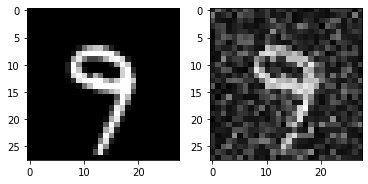

25  :  -0.7024387386801216 25
50  :  -0.6955061701328726 25
75  :  -0.6882366151083816 25
100  :  -0.6149041627307705 25
125  :  -0.6149041627307705 25
150  :  -0.5899587947240317 25
175  :  -0.547419776383711 25
200  :  -0.547419776383711 25
225  :  -0.5192575235333421 25
250  :  -0.5030362223673449 25
275  :  -0.5014602584206127 25
300  :  -0.4886232818241376 25
325  :  -0.4886232818241376 25
350  :  -0.4886232818241376 25
375  :  -0.4886232818241376 25
400  :  -0.4886232818241376 25
425  :  -0.4734899724188173 25
450  :  -0.4698619433861707 25
475  :  -0.46258835104599183 25
500  :  -0.46258835104599183 25
525  :  -0.46258835104599183 25
550  :  -0.4444254557963957 25
575  :  -0.4444254557963957 25
600  :  -0.4444254557963957 25
625  :  -0.4443496815511344 25
650  :  -0.43191815658400634 25
675  :  -0.43209140339684293 25
700  :  -0.41664930218843477 25
725  :  -0.4108409750177202 25
750  :  -0.4043581789076911 25
775  :  -0.40298054442062603 25
800  :  -0.40268982953025256 25
825  

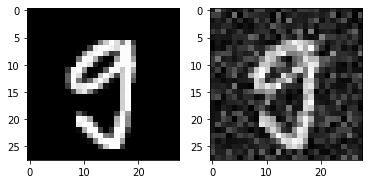

25  :  -0.8036338025358294 25
50  :  -0.8036338025358294 25
75  :  -0.7564678148709998 25
100  :  -0.7466230380477825 25
125  :  -0.7157290833451628 25
150  :  -0.7174168602557423 25
175  :  -0.6805879151076053 25
200  :  -0.6809115227215394 25
225  :  -0.6809115227215394 25
250  :  -0.6809115227215394 25
275  :  -0.6809115227215394 25
300  :  -0.6809115227215394 25
325  :  -0.6809115227215394 25
350  :  -0.6504009547781855 25
375  :  -0.6504105949264087 25
400  :  -0.6504105949264087 25
425  :  -0.6504105949264087 25
450  :  -0.6504105949264087 25
475  :  -0.6504105949264087 25
500  :  -0.6504105949264087 25
525  :  -0.6353675857113261 25
550  :  -0.6353675857113261 25
575  :  -0.597404928372923 25
600  :  -0.5972863438570257 25
625  :  -0.5972863438570257 25
650  :  -0.5972863438570257 25
675  :  -0.5972863438570257 25
700  :  -0.5972863438570257 25
725  :  -0.5972863438570257 25
750  :  -0.5953421831008276 25
775  :  -0.5953433497784213 25
800  :  -0.5953433497784213 25
825  :  -0.5

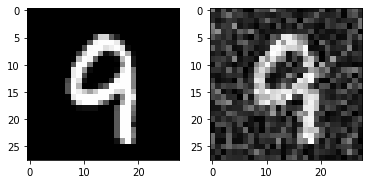

25  :  -0.7377600098661479 25
50  :  -0.7377600098661479 25
75  :  -0.7377600098661479 25
100  :  -0.7377600098661479 25
125  :  -0.7377600098661479 25
150  :  -0.722413661636294 25
175  :  -0.7118180023499543 25
200  :  -0.7126880918864433 25
225  :  -0.7148255768446985 25
250  :  -0.7048332373782129 25
275  :  -0.70215798237798 25
300  :  -0.6805781022844071 25
325  :  -0.6663430504327779 25
350  :  -0.6663430504327779 25
375  :  -0.6663430504327779 25
400  :  -0.6663430504327779 25
425  :  -0.612768075778992 25
450  :  -0.609257956329845 25
475  :  -0.609257956329845 25
500  :  -0.5928642772598274 25
525  :  -0.5928642772598274 25
550  :  -0.5928642772598274 25
575  :  -0.5928642772598274 25
600  :  -0.5928642772598274 25
625  :  -0.5928642772598274 25
650  :  -0.5928642772598274 25
675  :  -0.5903279468134446 25
700  :  -0.5917062905655701 25
725  :  -0.5788567154340885 25
750  :  -0.576976636038109 25
775  :  -0.5763282513420238 25
800  :  -0.5763282513420238 25
825  :  -0.5567225

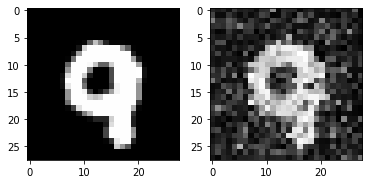

In [9]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((784,1)),adversarial_y[adv_ind],784)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,28,28,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(28,28),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(28,28),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best

In [0]:
file_ = open('adv_de_cnn_mnist_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [11]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

148.63612866401672
45.49690914154053
75.76648441382817
12.605703506710178


In [12]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

2309
875
1458.3015873015872
217.63695815057707


In [13]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

15.555374194324497
11.261308774427029
13.642522252940761
1.0795249478423583
